# My Capstone Project:
    Welcome to my final project for the Flatiron School. This is it, the big one, the one that defines my talent as a data       scientist. 
## The Problem:
    Picking good stocks is the problem. I intend to build a website that'll pick the best stock from a list of 4 that the    user will input.
    Retail investing as grown by leaps and bounds over the past few years; laregly due to stock trading apps like Robinhood and the recent Wall Street Bets/Gamestop drama. More and more average folks are getting into investing looking to make a quick buck.
    But stock research is HARD. Wherever you look, there are just as many voices saying a stock is a buy as there are telling you it's a dud.
    So the idea here is to use some simple time series forecasting to create a quick and easy way to decide how to throw away some money.

# Getting started
## Step 1: Import libraries
    Since this is the big project, we'll be importing everything. And I mean everything.

In [1]:
import pandas as pd
import pandas.tseries
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
import datetime as dt
import yfinance as yf
import requests
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import temporal_train_test_split
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from sklearn.linear_model import LinearRegression
from iexfinance.stocks import Stock
import random
from trafalgar import*

# Step 2: The data
    Thanks to Yahoo Finance (the library) I can research the stock history for most assets being traded today.
    So the first step will be to run through the process on a test stock, then create the functions necessary to do it with any stock. Let's use Citigroup, since its stock symbol is only 1 letter:C.

In [2]:
c = yf.Ticker("C")

In [3]:
c.info

{'zip': '10013',
 'sector': 'Financial Services',
 'fullTimeEmployees': 214000,
 'longBusinessSummary': 'Citigroup Inc., a diversified financial services holding company, provides various financial products and services to consumers, corporations, governments, and institutions in North America, Latin America, Asia, Europe, the Middle East, and Africa. The company operates in two segments, Global Consumer Banking (GCB) and Institutional Clients Group (ICG). The GCB segment offers traditional banking services to retail customers through retail banking, Citi-branded cards, and Citi retail services. It also provides various banking, credit card, lending, and investment services through a network of local branches, offices, and electronic delivery systems. The ICG segment offers wholesale banking products and services, including fixed income and equity sales and trading, foreign exchange, prime brokerage, derivative, equity and fixed income research, corporate lending, investment banking an

In [4]:
# get historical market data, here max is 5 years.
c.history(period="max")

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
1977-01-03   7.822093   7.872396   7.822093   7.872396     47952        0.0   
1977-01-04   7.872394   7.897545   7.847242   7.897545     34217        0.0   
1977-01-05   7.897544   7.897544   7.822090   7.847241     15422        0.0   
1977-01-06   7.822091   7.822091   7.721485   7.796939     39036        0.0   
1977-01-07   7.796939   7.822091   7.721485   7.822091     20482        0.0   
...               ...        ...        ...        ...       ...        ...   
2021-07-16  68.709999  68.760002  66.419998  66.900002  19278900        0.0   
2021-07-19  65.459999  66.070000  64.360001  65.080002  33318600        0.0   
2021-07-20  65.180000  66.779999  64.779999  66.290001  20568400        0.0   
2021-07-21  67.010002  68.250000  66.930000  67.889999  23387300        0.0   
2021-07-22  67.750000  67.790001  66.410004  66.930000  16519500        0.0   

            Stock Splits  
Date                      
1977-01-03           0.0  
1977-01-04           0.0  
1977-01-05           0.0  
1977-01-06           0.0  
1977-01-07           0.0  
...                  ...  
2021-07-16           0.0  
2021-07-19           0.0  
2021-07-20           0.0  
2021-07-21           0.0  
2021-07-22           0.0  

[11233 rows x 7 columns]

Well, no problem getting enough data for this one, unless my birthday is wrong, this is 44 years of data. Ok, let's do a train-test split and start predicting.....just kidding. One of the lessons learned from my last project is using too much data in my training set.
What we'll need to do is determine the period for our predictions: how far in advance do we intend to predict? I'd say no more than a month.

In [5]:
df=c.history(period="max")

In [6]:
df.tail()

Open       High        Low      Close    Volume  Dividends  \
Date                                                                          
2021-07-16  68.709999  68.760002  66.419998  66.900002  19278900        0.0   
2021-07-19  65.459999  66.070000  64.360001  65.080002  33318600        0.0   
2021-07-20  65.180000  66.779999  64.779999  66.290001  20568400        0.0   
2021-07-21  67.010002  68.250000  66.930000  67.889999  23387300        0.0   
2021-07-22  67.750000  67.790001  66.410004  66.930000  16519500        0.0   

            Stock Splits  
Date                      
2021-07-16           0.0  
2021-07-19           0.0  
2021-07-20           0.0  
2021-07-21           0.0  
2021-07-22           0.0

After some more thought, I've decided to predict 2 weeks out.

Another important decision to make is how we're going to split the data for training and testing; different splits give different results (better or worse). So let's make some loops and test a number of different training and testing values, and see what works best.

In [7]:
df1=df['Close']

In [8]:
trains=[14,30,60,180,360,720,900]
tests=[7,14,21,28,56]

In [9]:
def report_metrics(y_true, y_pred):
    print("Explained Variance:\n\t", metrics.explained_variance_score(y_true, y_pred))
    print("MAE:\n\t", metrics.mean_absolute_error(y_true, y_pred))
    print("RMSE:\n\t", metrics.mean_squared_error(y_true, y_pred, squared=False))
    print("r^2:\n\t", metrics.r2_score(y_true, y_pred))

In [10]:
df1.isna().sum()

0

In [11]:
cols=['Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']

In [12]:
outs = pd.DataFrame(columns=cols)

In [13]:
for test_val in tests:
    for train_val in trains:
        val_a=test_val+train_val
        df_mod=df1.tail(val_a)
        train_data, test_data = temporal_train_test_split(df_mod, test_size=test_val)
        test_sq=test_data.squeeze()
        train_sq=train_data.squeeze()
        arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=100,seasonal=True, m=1)
        y_pred = arima.predict(n_periods=test_data.shape[0])
        y_true=test_data
        ev_score= metrics.explained_variance_score(y_true, y_pred)
        mae= metrics.mean_absolute_error(y_true, y_pred)
        rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
        r2 = metrics.r2_score(y_true, y_pred)
        outs.loc[len(outs.index)] = [train_val,test_val,ev_score,mae,rmse,r2]       

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=54.163, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=54.483, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.589, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.707, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=160.551, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.356, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.356, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=52.382, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.695 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=92.879, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=91.013, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=91.588, Time=0.02 sec
 ARIMA(0,1

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=86.831, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=89.392, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=87.051, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=87.057, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=88.936, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=83.201, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=85.138, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=85.149, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=85.265, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=87.012, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.339 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=174.157, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=320.821, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=177.874, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=264

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166.878, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=164.401, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=165.882, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=164.960, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=164.144, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=164.377, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=164.954, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=165.368, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=166.370, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=162.146, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=162.421, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=162.386, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=162.961, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=163.375, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]      

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=1442.077, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1526.316, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=1443.705, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1517.125, Time=0.03 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=1435.552, Time=0.29 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=1437.339, Time=0.42 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=1435.230, Time=0.24 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=1433.468, Time=0.18 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=1435.247, Time=0.29 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=0.71 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.87 sec

Best model:  ARIMA(2,2,3)(0,0,0)[0]          
Total fit time: 5.041 seconds
Performing stepwise sear

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2562.229, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2573.947, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2566.952, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2568.692, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2572.023, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2560.557, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2558.567, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2560.554, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2564.662, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2562.499, Time=0.61 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2556.637, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2566.786, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2558.627, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2558.624, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2562.754, Time=0.06 sec
 ARIMA(1,1

In [14]:
outs.head()

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
0       14.0       7.0 -0.263137  2.128251  2.458587 -4.039090
1       30.0       7.0  0.100019  0.934656  1.189247 -0.179032
2       60.0       7.0 -0.628039  1.573249  1.815575 -1.747954
3      180.0       7.0 -0.145053  2.002649  2.320378 -3.488471
4      360.0       7.0  0.040634  1.441446  1.796824 -1.691485

In [15]:
outs[outs.MAE == outs.MAE.min()]

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
1       30.0       7.0  0.100019  0.934656  1.189247 -0.179032

In [16]:
outs[outs.RMSE == outs.RMSE.min()]

Train_Len  Test_Len   Exp_var       MAE      RMSE        R2
1       30.0       7.0  0.100019  0.934656  1.189247 -0.179032

In [17]:
outs[outs.R2 == outs.R2.min()]

Train_Len  Test_Len  Exp_var       MAE      RMSE         R2
15       30.0      21.0 -7.07047  7.947557  9.274031 -25.278265

# STONKS!!!

Now that we have a nice little bit of code to test various train/test splits, let's test it out on some more stocks. Finding files for the S&P 500, NASDAQ and Dow were very easy. So we can read them, and go through them all and see what we come up with.

In [18]:
sp_500=pd.read_csv('Data/constituents_csv.csv')

In [19]:
nsdq=pd.read_csv('Data/nasdaq.csv')

In [20]:
dow_30=pd.read_excel('Data/dow-jones-industrial-average-components.xls')

In [21]:
sp_500.head()

Symbol                 Name                  Sector
0    MMM                   3M             Industrials
1    ABT  Abbott Laboratories             Health Care
2   ABBV               AbbVie             Health Care
3   ABMD              Abiomed             Health Care
4    ACN            Accenture  Information Technology

In [22]:
sp_500.isna().sum()

Symbol    0
Name      0
Sector    0
dtype: int64

In [23]:
nsdq.head()

Unnamed: 0 Symbol                   Company Name
0           1    AAL  American Airlines Group, Inc.
1           2   AAME  Atlantic American Corporation
2           3   AAOI  Applied Optoelectronics, Inc.
3           4   AAON                     AAON, Inc.
4           5   AAPL                     Apple Inc.

In [24]:
nsdq.isna().sum()

Unnamed: 0      0
Symbol          0
Company Name    0
dtype: int64

In [25]:
dow_30.head()

Company Name Ticker Symbol  Weighting %
0                3M Company           MMM     0.038022
1  American Express Company           AXP     0.025567
2                Amgen Inc.          AMGN     0.048569
3                Apple Inc.          AAPL     0.028752
4          Caterpillar Inc.           CAT     0.039120

In [26]:
dow_30.isna().sum()

Company Name     0
Ticker Symbol    0
Weighting %      0
dtype: int64

In [27]:
dow_30.head()

Company Name Ticker Symbol  Weighting %
0                3M Company           MMM     0.038022
1  American Express Company           AXP     0.025567
2                Amgen Inc.          AMGN     0.048569
3                Apple Inc.          AAPL     0.028752
4          Caterpillar Inc.           CAT     0.039120

In [28]:
new_cols=['Name','Symbol','Weight%']
dow_30.columns=new_cols

In [29]:
dow_30.head()

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

What I want to do now is iterate through a variety of stocks, testing the various train/test splits, and coming up with a dataframe containing the stock symbol, the best train/test split, and the metrics.

In [30]:
stock = yf.Ticker(sp_500['Symbol'][0])

In [31]:
stock_df=stock.history(period='max')

In [32]:
stock_df.iloc[::-1]

Open        High         Low       Close   Volume  \
Date                                                                  
2021-07-22  201.509995  201.649994  198.679993  199.070007  1700500   
2021-07-21  201.130005  202.880005  199.960007  200.770004  1999100   
2021-07-20  198.339996  202.220001  198.070007  200.820007  2783300   
2021-07-19  197.789993  198.539993  195.110001  197.559998  3146300   
2021-07-16  203.119995  203.210007  198.910004  199.369995  2474100   
...                ...         ...         ...         ...      ...   
1970-01-08    1.492125    1.515440    1.488795    1.512109   304000   
1970-01-07    1.483799    1.495456    1.480468    1.492126   164800   
1970-01-06    1.468811    1.483799    1.467146    1.483799   176000   
1970-01-05    1.462150    1.470477    1.462150    1.468811   446400   
1970-01-02    1.460485    1.468811    1.458819    1.460485    72000   

            Dividends  Stock Splits  
Date                                 
2021-07-22        0.0           0.0  
2021-07-21        0.0           0.0  
2021-07-20        0.0           0.0  
2021-07-19        0.0           0.0  
2021-07-16        0.0           0.0  
...               ...           ...  
1970-01-08        0.0           0.0  
1970-01-07        0.0           0.0  
1970-01-06        0.0           0.0  
1970-01-05        0.0           0.0  
1970-01-02        0.0           0.0  

[13005 rows x 7 columns]

In [33]:
stock_df.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [34]:
dow_5=dow_30.head()

In [35]:
dow_5

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

In [36]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()

Empty DataFrame
Columns: [index, Symbol, Train_Len, Test_Len, Exp_var, MAE, RMSE, R2]
Index: []

In [37]:
fin_results=pd.DataFrame()

In [38]:
def tt_test (asset, train_list, test_list):
    """This function will take in a financial asset (stock, etf) as well as 2 lists of integers (training and testing days).
    Then the asset will be looked up through yahoo finance and gather the price history. It will then run through the values
    of the training and testing lists and run auto arima models on all of them. It will record the metrics and return a
    dataframe with all the results."""
    
    stock = yf.Ticker(asset)
    df1=stock.history(period='5y')
    df=df1['Close']
    print("Processing: ",stock)
    if len(df)<(train_list[0]+test_list[0]):
        print ('Not enough historical data to model.')
        return None
    else:
        
    
        for test_val in test_list:
            for train_val in train_list:
                val_a=test_val+train_val
                df_mod=df.tail(val_a)
                train_data, test_data = temporal_train_test_split(df_mod, test_size=test_val)
                test_sq=test_data.squeeze()
                train_sq=train_data.squeeze()
                arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
                        suppress_warnings=True, maxiter=100,seasonal=True, m=1)
                y_pred = arima.predict(n_periods=test_data.shape[0])
                y_true=test_data
                ev_score= metrics.explained_variance_score(y_true, y_pred)
                mae= metrics.mean_absolute_error(y_true, y_pred)
                rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
                r2 = metrics.r2_score(y_true, y_pred)        
                reslts.loc[len(reslts.index)] = [stock,train_val,test_val,ev_score,mae,rmse,r2]             

        return reslts

In [39]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_5['Symbol']:
    #print(each)
    stock_res_d5 = tt_test(each,trains,tests)
#    print(stock_res[(stock_res.MAE == stock_res.MAE.min()) & (stock_res.Exp_var == stock_res.Exp_var.max()) ])
    print (stock_res_d5[(stock_res_d5.MAE == stock_res_d5.MAE.min())])
#    if len(placeh)==1:
 #       fin_results.loc[len(fin_results.index)]=placeh
  #  else:
   #     placeh1=stock_res[(stock_res.MAE == stock_res.MAE.min()) & (stock_res.Exp_var == stock_res.Exp_var.max()) 
    #                      & (stock_res.Train_Len == stock_res.Train_Len.min())
     #                     & (stock_res.Test_Len == stock_res.Test_Len.min())]
      #  fin_results.loc[len(fin_results.index)]=placeh1

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.552, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.976, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.417, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.426, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53.317, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=55.277, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.622, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.637 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=134.931, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168.982, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129.450, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1820.546, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1824.002, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1821.984, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1821.470, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1822.615, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1819.051, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1821.944, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1823.014, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1818.729, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1820.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1820.738, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]       

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=791.864, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=797.674, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=799.510, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=799.385, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=798.076, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=792.159, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=793.571, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=796.099, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=793.777, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=795.472, Time=0.05 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.565 seconds
Performing stepwise search to

Processing:  yfinance.Ticker object <AXP>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74.634, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=68.788, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=70.350, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=185.265, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=70.785, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=70.630, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.811 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.017, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=138.091, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=869.623, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=871.540, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=871.517, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=870.612, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.708 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1891.703, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1887.708, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1887.043, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1887.359, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1886.075, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1887.772, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.364 seconds
Performing stepwise searc

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4080.070, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4075.235, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4077.140, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4055.024, Time=1.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4078.832, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4073.561, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4079.267, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4056.145, Time=1.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4052.868, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4079.320, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4079.490, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4076.635, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4054.261, Time=0.98 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4078.158, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4072.745, Time=0.20 sec
 ARIMA(3,1

 ARIMA(0,1,1)(0,0,0)[0]             : AIC=130.959, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.394 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=266.883, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=266.921, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268.510, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.429, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=267.648, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=268.737, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=268.163, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=270.532, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=269.491, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2107.963, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2093.410, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2094.877, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2106.047, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2094.940, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2094.726, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2096.703, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2091.541, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2093.062, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2092.848, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2093.015, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2094.826, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.232 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4792.671, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4781.080, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4781.737, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4791.343, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4782.575, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4782.073, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4784.057, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4779.932, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4781.387, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4780.880, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4780.604, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4782.869, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.085 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] int

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2121.443, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2109.754, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2110.753, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2119.469, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2111.373, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2111.047, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2113.013, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2107.795, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2109.411, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2109.085, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2108.794, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2111.052, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.078 seconds
Performing stepwise search 

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3912.947, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.767 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4782.568, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4769.817, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4770.456, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4781.083, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4771.429, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4770.970, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4772.928, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4768.474, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4770.061, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4769.595, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4769.125, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]    

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=234.169, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=236.833, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236.318, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=236.135, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=238.004, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=237.972, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=240.967, Time=0.07 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.837 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=803.705, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=804.667, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=804.649, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=802.009, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=806.542, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3508.816, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3507.559, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.440 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=47.925, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=47.749, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.746, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47.006, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177.127, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=46.247, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46.958, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=48.019, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.499 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1667.858, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1669.849, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1667.092, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.453 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2923.481, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2928.556, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2918.230, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2918.989, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2929.671, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2919.702, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2919.605, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2921.604, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2920.256, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.142 seconds
Performing 

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4469.740, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4464.308, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4460.448, Time=0.99 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4455.441, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4466.024, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4466.625, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4456.222, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4456.188, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4465.356, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4468.562, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4463.101, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4459.434, Time=0.53 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.186 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=78.933, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=154.389, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=153.098, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=151.983, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154.540, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=153.946, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=153.933, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=155.904, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=151.399, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=153.397, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=153.397, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=152.203, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=155.267, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.400 seconds
Performing stepwise search to minimize 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=162.534, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=192.209, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=163.471, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=172.605, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=415.100, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=160.871, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=163.977, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=159.288, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=159.948, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=158.559, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=160.301, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=162.392, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.196 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=939.982, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=941.143, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=938.400, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=938.583, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=943.206, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=940.385, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=940.386, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=942.385, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=941.903, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.464 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1881.207, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1896.380, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1893.863, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1894.395, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]        

In [40]:
stock_res_d5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 174
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     175 non-null    object 
 1   Train_Len  175 non-null    object 
 2   Test_Len   175 non-null    object 
 3   Exp_var    175 non-null    float64
 4   MAE        175 non-null    float64
 5   RMSE       175 non-null    float64
 6   R2         175 non-null    float64
dtypes: float64(4), object(3)
memory usage: 10.9+ KB


In [41]:
stock_res_d5.head()

Symbol Train_Len Test_Len   Exp_var       MAE  \
0  yfinance.Ticker object <MMM>        14        7 -1.085215  2.896388   
1  yfinance.Ticker object <MMM>        30        7 -0.022183  1.628433   
2  yfinance.Ticker object <MMM>        60        7  0.019558  1.631949   
3  yfinance.Ticker object <MMM>       180        7 -0.287820  1.754506   
4  yfinance.Ticker object <MMM>       360        7  0.022251  1.635361   

       RMSE        R2  
0  3.145175 -2.161375  
1  1.938849 -0.201363  
2  1.972687 -0.243663  
3  2.047308 -0.339532  
4  1.987119 -0.261927

In [42]:
stock_res_d5.tail()

Symbol Train_Len Test_Len   Exp_var        MAE  \
170  yfinance.Ticker object <CAT>        60       56  0.000000  12.510378   
171  yfinance.Ticker object <CAT>       180       56 -1.486945  20.851492   
172  yfinance.Ticker object <CAT>       360       56 -0.621362  16.436480   
173  yfinance.Ticker object <CAT>       720       56 -0.326448  14.719769   
174  yfinance.Ticker object <CAT>       900       56  0.000082  12.525372   

          RMSE        R2  
170  13.121852 -0.023020  
171  26.219280 -3.084467  
172  18.936444 -1.130545  
173  16.158049 -0.551214  
174  13.155593 -0.028288

In [43]:
for each in stock_res_d5.index:
    stock_res_d5['Symbol'][each]=str(stock_res_d5['Symbol'][each])
    stock_res_d5['Symbol'][each]=stock_res_d5['Symbol'][each].replace('>','')
    stock_res_d5['Symbol'][each]=stock_res_d5['Symbol'][each].split('<', 1)[-1]

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
stock_res_d5

Symbol Train_Len Test_Len   Exp_var        MAE       RMSE        R2
0      MMM        14        7 -1.085215   2.896388   3.145175 -2.161375
1      MMM        30        7 -0.022183   1.628433   1.938849 -0.201363
2      MMM        60        7  0.019558   1.631949   1.972687 -0.243663
3      MMM       180        7 -0.287820   1.754506   2.047308 -0.339532
4      MMM       360        7  0.022251   1.635361   1.987119 -0.261927
..     ...       ...      ...       ...        ...        ...       ...
170    CAT        60       56  0.000000  12.510378  13.121852 -0.023020
171    CAT       180       56 -1.486945  20.851492  26.219280 -3.084467
172    CAT       360       56 -0.621362  16.436480  18.936444 -1.130545
173    CAT       720       56 -0.326448  14.719769  16.158049 -0.551214
174    CAT       900       56  0.000082  12.525372  13.155593 -0.028288

[175 rows x 7 columns]

In [45]:
df_x=pd.DataFrame(columns=stock_res_d5.columns)

In [46]:
df_x=stock_res_d5.loc[stock_res_d5.index[0:35]]

In [47]:
df_x.sort_values(by=['MAE']).head()

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
8     MMM        30       14 -2.220446e-16  1.455716  1.811044 -0.244598
12    MMM       720       14 -2.220446e-16  1.455716  1.811044 -0.244598
13    MMM       900       14 -2.220446e-16  1.455716  1.811044 -0.244598
15    MMM        30       21  5.903764e-01  1.495587  1.899614  0.507038
9     MMM        60       14 -2.193911e-02  1.557796  1.904678 -0.376621

In [48]:
df_y=df_x.sort_values(by=['MAE']).head(2)

In [49]:
df_y

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
8     MMM        30       14 -2.220446e-16  1.455716  1.811044 -0.244598
12    MMM       720       14 -2.220446e-16  1.455716  1.811044 -0.244598

In [50]:
a=0
while a<=141:
    df_x=stock_res_d5.loc[stock_res_d5.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(2)
    df_y=pd.concat([df_y,df_ph])
    a+=35

In [51]:
df_y

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
8      MMM        30       14 -2.220446e-16  1.455716  1.811044 -0.244598
12     MMM       720       14 -2.220446e-16  1.455716  1.811044 -0.244598
8      MMM        30       14 -2.220446e-16  1.455716  1.811044 -0.244598
12     MMM       720       14 -2.220446e-16  1.455716  1.811044 -0.244598
66     AXP       180       56  7.995575e-01  2.147050  2.644699  0.799417
35     AXP        14        7  9.636264e-02  2.312994  3.118099  0.086774
71    AMGN        30        7  0.000000e+00  1.304286  1.728579 -1.065180
72    AMGN        60        7  0.000000e+00  1.304286  1.728579 -1.065180
111   AAPL       900        7 -6.982642e-02  1.573754  2.113508 -0.088963
110   AAPL       720        7 -7.617848e-02  1.581981  2.127865 -0.103808
141    CAT        30        7 -4.717259e-01  3.064428  3.609392 -1.030076
159    CAT       720       21 -8.264442e-04  3.197051  3.811401 -0.024560

Ok, so I managed to get some data on train/test splits, but I still need more. So far it looks like 720 and 360 are leading. But let's run through the entire dow 30, and see what that'll get us.

In [52]:
df_y['Train_Len'].value_counts()

30     4
720    4
14     1
900    1
180    1
60     1
Name: Train_Len, dtype: int64

In [53]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_30['Symbol']:
    stock_res_d30 = tt_test(each,trains,tests)
    print (stock_res_d30[(stock_res_d30.MAE == stock_res_d30.MAE.min())])
for each in stock_res_d30.index:
    stock_res_d30['Symbol'][each]=str(stock_res_d30['Symbol'][each])
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].replace('>','')
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].split('<', 1)[-1]

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=55.134, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51.552, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.976, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=54.417, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=53.426, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=53.317, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=55.277, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=53.622, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.259 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=134.931, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168.982, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=129.450, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] int

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1820.546, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1824.002, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1821.984, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1821.470, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1822.615, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1819.051, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1821.944, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1823.014, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1818.729, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1820.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1820.738, T

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=791.864, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=797.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=799.510, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=799.385, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=798.076, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=792.159, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=793.571, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=796.099, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=793.777, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=795.472, Time=0.05 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.388 seconds
Performing stepwise search to

Processing:  yfinance.Ticker object <AXP>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74.634, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=68.788, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=70.350, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=185.265, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=70.785, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=70.630, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.816 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.017, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=138.091, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=869.623, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=871.540, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=871.517, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=870.612, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.742 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1891.703, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1887.708, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1887.043, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1887.359, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1886.075, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1887.772, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.398 seconds
Performing stepwise searc

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4080.070, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4075.235, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4077.140, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4055.024, Time=1.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4078.832, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4073.561, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4079.267, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4056.145, Time=1.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4052.868, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4079.320, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4079.490, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4076.635, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4054.261, Time=0.96 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4078.158, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4072.745, Time=0.21 sec
 ARIMA(3,1

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=266.883, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=266.921, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268.510, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.429, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=267.648, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=268.737, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=268.163, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=270.532, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=269.491, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=267.821, Time=0.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2094.726, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2096.703, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2091.541, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2093.062, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2092.848, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2093.015, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2094.826, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.198 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3932.787, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3921.999, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3922.929, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3931.151, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3922.929, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] int

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4782.575, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4782.073, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4784.057, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4779.932, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4781.387, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4780.880, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4780.604, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4782.869, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.100 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=69.152, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=67.544, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=62.976, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=195.137, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2121.443, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2109.754, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2110.753, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2119.469, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2111.373, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2111.047, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2113.013, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2107.795, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2109.411, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2109.085, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2108.794, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2111.052, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.056 seconds
Performing stepwise search 

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3912.947, Time=0.15 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.759 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4782.568, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4769.817, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4770.456, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4781.083, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4771.429, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4770.970, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4772.928, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4768.474, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4770.061, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4769.595, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4769.125, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]    

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=234.169, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=236.833, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=236.318, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=236.135, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=238.004, Time=0.15 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=237.972, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=240.967, Time=0.07 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.841 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=803.705, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=804.667, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=804.649, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=802.009, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=806.542, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]   

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3508.816, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3507.559, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.447 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=47.925, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=47.749, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44.746, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47.006, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177.127, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=46.247, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=46.958, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=48.019, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.445 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1667.858, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1669.849, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1667.092, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.453 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2923.481, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2928.556, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2918.230, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2918.989, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2929.671, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2919.702, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2919.605, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2921.604, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2920.256, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.137 seconds
Performing 

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4469.740, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4464.308, Time=0.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4460.448, Time=1.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4455.441, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4466.024, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4466.625, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=4456.222, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4456.188, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4465.356, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4468.562, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4463.101, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4459.434, Time=0.52 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.215 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=78.933, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=154.389, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=153.098, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=151.983, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=154.540, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=153.946, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=153.933, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=155.904, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=151.399, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=153.397, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=153.397, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=152.203, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=155.267, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.399 seconds
Performing stepwise search to minimize 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=162.534, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=192.209, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=163.471, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=172.605, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=415.100, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=160.871, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=163.977, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=159.288, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=159.948, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=158.559, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=160.301, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=162.392, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.190 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=939.982, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=941.143, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=938.400, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=938.583, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=943.206, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=940.385, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=940.386, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=942.385, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=941.903, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.460 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1881.207, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1896.380, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1893.863, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1894.395, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]        

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1679.275, Time=0.21 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1672.017, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1666.027, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1685.856, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1668.056, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1666.718, Time=0.50 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1667.408, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1685.025, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1677.281, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1666.509, Time=0.15 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1670.023, Time=0.14 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.342 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3041.651, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3079.165, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1672.972, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1682.918, Time=0.20 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1675.717, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1669.727, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1689.257, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1671.465, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1670.123, Time=0.43 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1670.983, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1688.386, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1680.929, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1670.196, Time=0.14 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1673.727, Time=0.13 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.026 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.807, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3040.505, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3078.956, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3070.346, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3072.249, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3076.956, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3065.009, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3066.106, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3038.517, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3067.409, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3039.898, Time=0.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3067.957, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3046.831, Time=0.36 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3039.838, Time=1.55 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3036.517, Time=0.21 sec
 ARIMA(2,1,2)(0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3056.749, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3036.009, Time=0.21 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3029.413, Time=0.85 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 10.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3704.522, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3742.776, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3732.881, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3734.675, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3740.800, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3730.005, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3730.435, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3733.571, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3733.730, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3730.885, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3722.883, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3719.914, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3720.880, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3708.421, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3690.806, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3716.972, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3717.315, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3720.942, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3720.890, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3717.921, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3718.886, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3706.427, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.66 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.302 seconds
         

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=63.429, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.427, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.160, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=325.300, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=45.414, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=45.403, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=47.409, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.545 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=98.224, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=97.244, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=99.101, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=99.050, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=95.381, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Tim

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=945.639, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=960.670, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=945.339, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=945.342, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=947.339, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=941.816, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=943.537, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=943.541, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=943.854, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=945.537, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.516 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1753.021, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1776.605, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1762.656, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2104.436, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2115.226, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2098.797, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2099.536, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2114.279, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2100.721, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2100.735, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2102.521, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2098.200, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2100.098, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2100.118, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2098.973, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2101.786, Time=0.24 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.725 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=80.706, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.574, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82.553, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=81.091, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=84.633, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.344 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=195.751, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=305.608, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=193.723, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=258.844, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=674.484, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=194.280, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=194.694, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=19

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187.358, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=187.665, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188.059, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185.358, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=188.860, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.170 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=581.950, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=577.610, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=577.745, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=577.479, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=576.664, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=578.810, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.272 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=123

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=576.295, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=572.794, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=571.898, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=576.035, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=573.283, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=573.318, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=575.355, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=572.599, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1213.864, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1214.378, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1214.312, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1214.542, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=4292.242, Time=0.73 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4299.491, Time=1.12 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=4294.703, Time=1.89 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=4289.205, Time=0.77 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=4293.637, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=4301.237, Time=0.67 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=4292.006, Time=0.64 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=4292.028, Time=0.66 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4294.586, Time=0.47 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=4291.324, Time=0.30 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4298.896, Time=0.90 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=4293.824, Time=0.71 sec

Best model:  ARIMA(3,1,4)(0,0,0)[0]          
Total fit time: 23.275 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=72.378, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=187.090, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=156.894, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=169.835, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=411.979, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=158.832, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=158.832, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=158.525, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.721 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=295.248, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=365.163, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=291.154, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=320.444, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=821.784, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=893.422, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=895.358, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=895.346, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=894.509, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=897.055, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.517 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1961.784, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1961.741, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1961.978, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1960.355, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1963.017, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.563 seconds
Performing stepwise search

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3546.368, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3515.502, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3521.025, Time=0.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3516.332, Time=1.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3509.144, Time=1.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3514.840, Time=0.86 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3523.877, Time=0.67 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3509.867, Time=1.37 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3514.848, Time=0.42 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3511.021, Time=1.92 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3508.771, Time=0.96 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3514.298, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3514.964, Time=0.36 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3523.031, Time=0.56 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3509.368, Time=0.68 sec
 ARIMA(2,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2915.609, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2962.194, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2919.529, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2926.345, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2960.402, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2914.947, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2913.743, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2914.372, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2920.010, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2907.741, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2909.543, Time=0.85 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2909.591, Time=0.62 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2915.063, Time=0.15 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2906.002, Time=0.24 sec
 ARIMA(0,1,3)(0

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=36.560, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=30.214, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.422, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=154.935, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=32.011, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=32.125, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=34.138, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.843 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=63.838, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64.536, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64.391, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=61.889, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1361.539, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1389.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1360.964, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1366.995, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1387.392, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1361.241, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1361.990, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1361.476, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1358.966, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1359.242, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1359.992, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1364.997, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1359.477, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.617 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2400.111, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2404.364, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2404.671, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2401.954, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2402.009, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2403.265, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=2405.829, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2405.899, Time=0.25 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 6.637 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2909.022, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2956.896, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2914.538, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3940.472, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3940.108, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3914.482, Time=1.02 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3944.469, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3938.942, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3942.472, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3930.126, Time=0.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3910.514, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3938.498, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3938.130, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3912.508, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3942.495, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3936.969, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3940.498, Time=0.08 sec
 ARIMA(3,1,1)(0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=65.730, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=66.636, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=58.425, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=61.768, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=181.649, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=59.820, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=60.068, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=62.714, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.761 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.448, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=109.355, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=109.364, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105.524,

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=233.305, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=234.978, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=234.901, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=234.277, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.375 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=774.407, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=775.489, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=775.202, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=774.228, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=775.959, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.581 seconds
Performing stepwise search to minim

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1721.672, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1701.116, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1720.325, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1723.121, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1723.579, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1697.415, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1719.617, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1719.811, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1699.264, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1718.478, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1721.269, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1721.723, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]  

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1594.564, Time=0.11 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1591.724, Time=0.17 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1592.264, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1594.969, Time=0.03 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1595.119, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1593.768, Time=0.22 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1593.719, Time=0.24 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 4.010 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2980.114, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2992.819, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2984.566, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2986.038, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2991.542, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2982.256, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1594.560, Time=0.18 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1594.564, Time=0.21 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 3.992 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2977.681, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2989.832, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2981.646, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2983.072, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2988.482, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2979.713, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2980.979, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2972.968, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2978.716, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2962.573, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2962.514, Time=0.56 sec
 ARIMA(4,1,0)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2982.913, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2984.202, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2976.055, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2981.679, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2965.188, Time=0.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2965.032, Time=0.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2972.201, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2966.043, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2983.769, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2974.158, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2967.157, Time=0.66 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2963.940, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2980.693, Time=0.13 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2971.239, Time=0.05 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2965.013, Time=0.37 sec
 ARIMA(4,1

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2964.289, Time=0.76 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2961.104, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2977.254, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2968.180, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2972.160, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2961.369, Time=0.25 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2979.231, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2971.661, Time=0.24 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2970.153, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2963.344, Time=0.45 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 5.272 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3647.752, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3656.544, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3647.760, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2961.315, Time=0.86 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2960.073, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2970.654, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2960.016, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2976.686, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2967.016, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2970.989, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2978.935, Time=0.04 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2968.982, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2962.024, Time=0.40 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.711 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3643.402, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3653.146, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3644.197, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3209.616, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3185.577, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3210.094, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3187.208, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3183.846, Time=0.23 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3187.378, Time=0.63 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 10.495 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3887.266, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3916.496, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3899.653, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3903.024, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3915.404, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3891.664, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3894.174, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[

 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3178.662, Time=0.56 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 9.269 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3877.635, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3907.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3890.568, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3894.024, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3906.162, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3881.635, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3884.287, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3849.997, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3885.743, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3851.332, Time=0.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3881.570, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3849.901, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3852.559, Time=0.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3870.017, Time=0.30 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3854.554, Time=1.86 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3857.134, Time=0.43 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3856.462, Time=1.42 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3851.582, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3868.887, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3878.939, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3882.846, Time=0.40 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3853.571, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3882.911, Time=0.10 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3856.276, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3851.679, Time=0.25 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3855.516, Time=0.71 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 11.223 second

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3842.169, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3837.860, Time=0.28 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3841.421, Time=0.70 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 11.580 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=63.216, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=62.296, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.525, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=61.288, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=182.176, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=61.470, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.486, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=62.436, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.677 seconds
Performing stepwise search to 

Processing:  yfinance.Ticker object <MCD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=59.169, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.541, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=57.103, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.386, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=53.782, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.069, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=54.229, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.805 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=120.010, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=126.978, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=115.626, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] inter

 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4345.509, Time=0.52 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 12.565 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=65.394, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.628, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=59.978, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=59.842, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.368, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.436, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=61.474, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=63.165, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.332 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=117.252, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=128.909, Tim

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=4325.847, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=4338.886, Time=0.27 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=4344.451, Time=0.50 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 12.913 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=67.284, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.489, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=61.816, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=62.249, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.449, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=63.196, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=63.472, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=65.838, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.476 seconds
Performing stepwise search to 

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=57.123, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=194.345, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=58.256, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=59.273, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=61.344, Time=0.65 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.048 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=129.259, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=136.384, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=124.259, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=125.500, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=414.008, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=125.793, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=125.729, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=50.523, Time=0.01 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.510 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=115.463, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=115.695, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=114.859, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=114.805, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.311 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=262.464, Time=0.02 sec
 ARIM

Processing:  yfinance.Ticker object <MRK>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33.498, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=37.866, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26.566, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=33.030, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=163.553, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28.726, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29.564, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=30.595, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.852 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=65.532, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=68.395, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=69.083, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] inter

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=31.337, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=31.712, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=29.139, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=31.029, Time=0.04 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=38.784, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.085 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=75.532, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=75.324, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=74.118, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73.875, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=76.106, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.229 seconds
Performing stepwise search to minimize ai

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=155.711, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=157.532, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=157.507, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=153.809, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=158.522, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.385 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=461.435, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=463.137, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=463.168, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=459.438, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=464.365, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.684 seconds
Performing stepwise search to m

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=157.822, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=156.145, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=160.359, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=463.924, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=465.396, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=465.458, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=461.946, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=466.723, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.491 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1166.852, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1905.055, 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=466.852, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=466.841, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=466.559, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=463.164, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=464.094, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=463.498, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=465.074, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=464.788, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=464.054, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.015 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1161.333, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1198.407, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2058.960, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2084.538, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2053.867, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2058.008, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2083.978, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2055.672, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2055.714, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2057.422, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2054.404, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.520 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3737.077, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3783.192, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3732.213, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3737.123, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.647 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2061.258, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2086.072, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2056.449, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2060.582, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2085.536, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2058.195, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2058.256, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2059.876, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2057.073, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.546 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3730.323, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=315.230, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=314.136, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=316.106, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=316.094, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=312.292, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=317.909, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.234 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=978.954, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=986.777, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=986.897, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=987.088, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=985.551, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=988.854, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=988.869, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept  

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=87.453, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.662, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=89.317, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.231 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=179.851, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=217.866, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=177.219, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=201.704, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=382.234, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=179.152, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=179.176, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=180.251, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.698 seconds
Performing stepwise search to 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3520.535, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3517.462, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3517.193, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3517.303, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3517.642, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3518.616, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3518.756, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3519.901, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3517.590, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.302 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.334, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=46.918, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=50.894, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]          

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2918.077, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2918.204, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2918.725, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2913.648, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2916.557, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2920.130, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2917.389, Time=0.34 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.78 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.073 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3497.080, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3493.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3493.238, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3493.355, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]         

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1055.150, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1048.564, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1050.434, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1050.448, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1046.643, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1051.806, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.264 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2285.302, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2283.290, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.813, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2284.865, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2281.622, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2286.159, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]         

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5132.216, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5113.084, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5129.381, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5129.355, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5134.958, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=5133.232, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5128.313, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5131.563, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5131.348, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.87 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 11.195 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.847, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : 

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1186.025, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1173.694, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1182.656, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1183.265, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1175.687, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1181.283, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1182.037, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1184.256, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1183.820, Time=0.27 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.265 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2278.677, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2272.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2274.480, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] int

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4957.624, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4960.211, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4959.729, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4960.167, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4958.468, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4955.702, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4953.759, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4955.718, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4957.495, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4951.958, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4958.403, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4953.904, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4953.919, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=346.487, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=448.427, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=340.552, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=399.656, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=831.131, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=342.495, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=342.498, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=344.496, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.349 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1130.479, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1132.452, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1132.448, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AI

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4950.842, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4958.037, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4952.796, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4952.805, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4955.184, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.348 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6118.555, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6119.343, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6120.599, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6120.717, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6117.344, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6118.522, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=312.607, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=314.556, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=314.555, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=311.155, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.507 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=929.126, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=938.793, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=938.413, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=938.902, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=936.799, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=933.133, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=936.113, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=930.410, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : A

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=941.734, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=942.229, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=940.154, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=936.714, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=939.610, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=934.253, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=918.421, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=928.283, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=935.729, Time=0.49 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=916.814, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=932.544, Time=0.09 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=918.586, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=933.675, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=927.874, Time=0.12 sec
 ARIMA(2,1,5)(0,0,0)[0] inter

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=936.008, Time=0.34 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=919.235, Time=1.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=917.471, Time=0.25 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=932.787, Time=0.08 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=919.257, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=934.063, Time=0.06 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=928.170, Time=0.11 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=920.422, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=915.472, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=930.788, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=927.123, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=917.236, Time=0.81 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=917.257, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=932.064, Time=0.03 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=926.170, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]  

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=926.190, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=916.962, Time=0.52 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=916.972, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=931.414, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=925.606, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=916.971, Time=0.17 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=918.009, Time=0.20 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 5.281 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1551.637, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1564.133, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1562.635, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1563.082, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1562.651, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1560.913, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] inter

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=925.318, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=916.680, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=930.606, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=925.313, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=916.449, Time=0.19 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=917.940, Time=0.20 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 5.191 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1551.666, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1563.342, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1561.853, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1562.302, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1561.938, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1560.199, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept

 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4356.572, Time=0.16 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.518 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5920.524, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5553.375, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=5467.630, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=5424.967, Time=0.08 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=5381.374, Time=0.09 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=5356.863, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5358.862, 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2267.861, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2279.387, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2274.718, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2276.169, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2278.511, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2271.291, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2271.912, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2269.136, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2274.986, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2272.569, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2272.880, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2273.695, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2272.763, Time=0.66 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2267.230, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2270.466, Time=0.05 sec
 ARIMA(2,1

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2557.174, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2378.225, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2268.618, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2262.313, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2258.325, Time=0.10 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2351.102, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=2259.772, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2260.166, Time=0.11 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=2338.420, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.348 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5151.041, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5146.369, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5157.234, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5148.001, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=5147.993, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5150.855, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5149.996, Time=0.10 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.764 seconds
                            Symbol Train_Len Test_Len   Exp_var       MAE  \
220  yfinance.Ticker object <CSCO>       180       14  0.297811  0.256506   

         RMSE        R2  
220  0.342407  0.297796  
Processing:  yfinance.Ticker object <HD>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=81.598, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=75.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=984.907, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=979.972, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=979.620, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=979.722, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=978.602, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=981.599, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.302 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2190.175, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2205.383, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2197.104, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2199.821, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2204.324, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2188.920, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2187.764, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] inte

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4027.748, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4038.280, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4029.026, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4026.809, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4045.556, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4027.727, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4027.231, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4038.108, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=4028.662, Time=0.17 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.854 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4904.988, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4926.063, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4916.496, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4918.924, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=152.969, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=154.110, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=154.218, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=156.298, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=154.888, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=324.571, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=324.700, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=322.606, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=323.427, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=326.125, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=324.355, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=324.470, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2736.362, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2755.997, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2739.094, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2739.360, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2755.825, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2736.433, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2743.040, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2715.624, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2729.744, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2703.018, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2714.291, Time=0.34 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2703.314, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2697.363, Time=0.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2716.374, Time=0.99 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=2696.688, Time=1.09 sec
 ARIMA(5,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3267.224, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3288.267, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3269.858, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3270.034, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3287.604, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3267.197, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3272.031, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3271.844, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3258.799, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3265.460, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3236.191, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3244.534, Time=0.15 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3234.032, Time=0.58 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3225.976, Time=0.71 sec
 ARIMA(3,1,3)(0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=54.758, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=56.575, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.281, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.851, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.040, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=53.339, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.531, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.103, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.633 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=108.257, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=117.117, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=102.177, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=104.208, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=381.

 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.903 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=200.118, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=202.028, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=202.016, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=198.519, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=203.972, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.325 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=612.163, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=608.460, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=606.282, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=606.393, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=606.477, Ti

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=787.721, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=788.986, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=785.421, Time=0.09 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.835 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1766.660, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1796.365, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1784.226, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1788.172, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1794.522, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1771.406, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1775.988, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1761.197, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1776.662, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1760.875, Time=0.39 sec
 ARIMA(4,1,1)(0,0,0)[0] i

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1773.978, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1760.130, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1774.465, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1759.736, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1757.996, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1765.229, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1759.710, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1773.974, Time=0.06 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1763.371, Time=0.11 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1761.732, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1756.214, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1772.697, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1763.479, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1757.940, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1757.968, Time=0.28 sec
 ARIMA(3,1

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1763.563, Time=0.35 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1762.863, Time=0.75 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1763.453, Time=0.33 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1764.739, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1760.358, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1768.620, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1764.556, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1761.629, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1760.939, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1770.263, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1761.546, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1766.495, Time=0.11 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1762.829, Time=0.25 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 4.262 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1765.266, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1770.977, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1761.241, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1756.000, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1763.554, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1757.136, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1756.538, Time=0.58 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1757.193, Time=0.29 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1758.281, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1754.167, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1761.767, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1757.538, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1755.314, Time=0.20 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1754.739, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1763.422, Time=0.04 sec
 ARIMA(1,1

 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1740.319, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1747.995, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1740.835, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1744.867, Time=0.11 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1741.932, Time=0.31 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 4.620 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3179.451, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3232.425, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3210.905, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3217.197, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3230.853, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3184.958, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3192.258, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3172.907, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3492.946, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3496.945, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3486.951, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3487.160, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3495.950, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3488.951, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3488.951, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3490.951, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3486.259, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3488.256, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3488.256, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3486.500, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3490.255, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.868 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=56.633, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=48.564, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.100, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.459, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=50.712, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=50.639, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=52.558, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.758 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=122.126, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=153.711, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=124.673, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=134.950, Time=0.02 sec
 ARIMA

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=947.814, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=948.569, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=949.522, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=949.577, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=951.522, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=947.774, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=949.638, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=949.658, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=947.946, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=950.820, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.462 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1905.801, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1906.965, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1900.049, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4175.121, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4175.137, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4166.141, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4177.450, Time=0.56 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4175.422, Time=0.49 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4176.978, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4166.073, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4175.052, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4175.040, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=4176.714, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4176.630, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4173.104, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4174.685, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=4176.846, Time=0.05 sec
 ARIMA(3,1,2)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5514.918, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5470.266, Time=0.86 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5505.352, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5489.520, Time=0.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5475.013, Time=1.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5505.055, Time=1.00 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5484.640, Time=0.55 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5465.405, Time=1.30 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5467.356, Time=1.35 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=5466.672, Time=2.02 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=5482.698, Time=1.17 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=5466.343, Time=2.21 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=5467.611, Time=0.66 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 15.963 seconds
Per

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=81.302, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=79.996, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=80.836, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=209.393, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=82.640, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=82.014, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=83.563, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.679 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=152.040, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=151.034, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=149.904, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=150.510, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=151.879

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=336.412, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=338.411, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=338.411, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=335.716, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=340.406, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.221 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1094.920, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1089.648, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1089.130, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1088.986, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1090.164, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1090.930, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1090.922, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0]         

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2401.340, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2411.856, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2401.996, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2402.351, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2386.049, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2403.557, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2407.148, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2405.046, Time=0.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2401.685, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2411.115, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2401.802, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2402.535, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2388.802, Time=0.26 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.869 seconds
Perf

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1426.052, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1410.223, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1411.107, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1424.275, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1411.928, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1411.930, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1406.232, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1411.828, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1413.878, Time=0.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1413.699, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1406.921, Time=0.47 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1404.565, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1410.237, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1410.232, Time=0.05 sec
 ARIMA(3,1,1)(0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1406.230, Time=0.28 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 3.872 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1725.485, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1710.867, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1711.034, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1723.870, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1712.866, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1712.866, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1714.866, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1709.377, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1711.375, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1711.374, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1709.563, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]    

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1721.745, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.132 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16.452, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4.081, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=9.639, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=154.553, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4.412, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5.133, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5.263, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.853 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=40.305, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34.163, Time=0.01 sec


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=35.489, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.681, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=32.200, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=31.010, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=40.922, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.882 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.899, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=114.899, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=114.899, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.352, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.477 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 s

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2022.589, Time=0.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2027.820, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2022.602, Time=0.28 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2020.942, Time=0.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2042.747, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2027.142, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2026.294, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2021.538, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2042.891, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2020.954, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2038.558, Time=0.11 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=inf, Time=0.32 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 5.453 seconds
Performing ste

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3762.208, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3763.138, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3757.507, Time=0.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3725.801, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3762.135, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3748.462, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3740.387, Time=0.37 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3723.979, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3761.626, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3762.612, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3757.201, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3725.346, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3761.730, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3747.754, Time=0.13 sec
 ARIMA(3,1,1)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4550.990, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4543.900, Time=0.88 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4505.771, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4549.732, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4534.801, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4526.208, Time=0.42 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4505.629, Time=0.30 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.775 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.611, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.751, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=50.032, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.896, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AI

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=120.210, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=118.213, Time=0.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=120.211, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=137.447, Time=0.02 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0] intercept
Total fit time: 0.924 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=309.420, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=311.413, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=311.409, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=308.364, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.373 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1143.427, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1142.576, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1142.164, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1142.397, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1140.591, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1143.085, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.526 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2166.394, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2166.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2168.103, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2168.144, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2164.862, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2170.211, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.949 seconds
Performing 

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1137.123, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.481 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2157.162, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2157.905, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2159.354, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2159.400, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2155.984, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2161.505, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.707 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2701.450, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2698.001, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2699.876, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2699.878, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]           

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=489.343, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=484.798, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=486.225, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=486.441, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=485.179, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=488.185, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.549 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1129.599, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1127.895, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1128.169, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1128.344, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1125.905, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1129.128, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.413 seconds
Performing stepwi

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=61.323, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.558 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.799, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=98.413, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=98.328, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=97.014, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=100.301, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.242 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=201.806, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=244.046, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=198.500, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=217.011, Time=0.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2793.917, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2809.636, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2791.122, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2792.869, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2808.920, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2792.398, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2792.615, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2790.904, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2792.071, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2792.334, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2792.685, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2792.847, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.718 seconds
Performing stepwise search 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=252.515, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=368.715, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=247.407, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=318.327, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=761.968, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=249.318, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=249.327, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=251.284, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.733 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=727.104, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=728.682, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=728.706, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
stock_res_d30.info

<bound method DataFrame.info of      Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
0       MMM        14        7 -1.085215e+00  2.896388  3.145175 -2.161375
1       MMM        30        7 -2.218283e-02  1.628433  1.938849 -0.201363
2       MMM        60        7  1.955766e-02  1.631949  1.972687 -0.243663
3       MMM       180        7 -2.878204e-01  1.754506  2.047308 -0.339532
4       MMM       360        7  2.225113e-02  1.635361  1.987119 -0.261927
...     ...       ...      ...           ...       ...       ...       ...
1045    WMT        60       56 -1.021074e-01  1.859599  2.093813 -0.306830
1046    WMT       180       56  1.110223e-16  1.713821  2.396052 -0.711337
1047    WMT       360       56 -1.500608e-04  1.569951  2.186984 -0.425720
1048    WMT       720       56 -6.651733e-01  3.652480  4.348661 -4.637079
1049    WMT       900       56 -5.375263e-01  3.416385  4.097732 -4.005302

[1050 rows x 7 columns]>

In [55]:
len(stock_res_d30)

1050

In [56]:
df_y_d30=pd.DataFrame(columns=stock_res_d30.columns)

In [57]:
df_y_d30

Empty DataFrame
Columns: [Symbol, Train_Len, Test_Len, Exp_var, MAE, RMSE, R2]
Index: []

In [58]:
a=2
b=len(stock_res_d30)
while a<=(b-35):
    df_x=stock_res_d30.loc[stock_res_d30.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_d30=pd.concat([df_y,df_ph])
    a+=35

In [59]:
df_y_d30

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE         R2
8       MMM        30       14 -2.220446e-16  1.455716  1.811044  -0.244598
12      MMM       720       14 -2.220446e-16  1.455716  1.811044  -0.244598
8       MMM        30       14 -2.220446e-16  1.455716  1.811044  -0.244598
12      MMM       720       14 -2.220446e-16  1.455716  1.811044  -0.244598
66      AXP       180       56  7.995575e-01  2.147050  2.644699   0.799417
35      AXP        14        7  9.636264e-02  2.312994  3.118099   0.086774
71     AMGN        30        7  0.000000e+00  1.304286  1.728579  -1.065180
72     AMGN        60        7  0.000000e+00  1.304286  1.728579  -1.065180
111    AAPL       900        7 -6.982642e-02  1.573754  2.113508  -0.088963
110    AAPL       720        7 -7.617848e-02  1.581981  2.127865  -0.103808
141     CAT        30        7 -4.717259e-01  3.064428  3.609392  -1.030076
159     CAT       720       21 -8.264442e-04  3.197051  3.811401  -0.024560
1015    WMT        14        7 -7.970009e+00  0.759850  0.959125 -15.173741
982     WBA        60        7  0.000000e+00  1.041428  1.118359  -6.527480
983     WBA       180        7  0.000000e+00  1.041428  1.118359  -6.527480

In [60]:
df_y['Train_Len'].value_counts()

30     4
720    4
14     1
900    1
180    1
60     1
Name: Train_Len, dtype: int64

In [61]:
df_y['Test_Len'].value_counts()

7     6
14    4
21    1
56    1
Name: Test_Len, dtype: int64

So we have a clear winner in the Test Length. The Training Length is still a little close, as far as the best; although the worst seems pretty clear. 30 days seems to be a bad number to use.

Next on the agenda is to run through this modeling again, but with 50 stocks from the S&P 500

In [62]:
picks_sp50=[]
for i in range (0,50):
    x = random.randint(0,len(sp_500))
    picks_sp50.append(x)

In [63]:
tests=[7, 14, 21, 28]

In [64]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in sp_500['Symbol'][picks_sp50]:
    stock_res_sp50 = tt_test(each,trains,tests)
    print (stock_res_sp50[(stock_res_sp50.MAE == stock_res_sp50.MAE.min())])
for each in stock_res_sp50.index:
    stock_res_sp50['Symbol'][each]=str(stock_res_sp50['Symbol'][each])
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].replace('>','')
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].split('<', 1)[-1]
df_x_sp50=pd.DataFrame(columns=stock_res_sp50.columns)
df_y_sp50=df_x_sp50.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <PENN>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.062, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=48.005, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=45.823, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.455 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=112.002, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=113.937, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=113.859, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111.506, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=115.539, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.557 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=139.833, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=150.104, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=135.808, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=137.483, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=350.024, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=136.159, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=135.854, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=138.685, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.540 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=135.677, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=114.082, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=123.371, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=377.985, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=115.792, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=115.834, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=117.804, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.673 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=325.385, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=231.959, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=279.538, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=753.9

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=223.276, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=224.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=224.953, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=222.511, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=226.887, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=729.951, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=724.278, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=724.743, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=724.542, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=723.763, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=725.951, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.241 seconds
Performing stepwise search 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1578.695, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1589.216, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1590.696, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1590.722, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1587.633, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1593.375, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1593.663, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1591.124, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1594.887, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1592.090, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1592.291, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1591.627, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1582.498, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1577.137, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]          

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1575.109, Time=0.24 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1566.933, Time=0.58 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1566.932, Time=0.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1578.380, Time=0.62 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1572.618, Time=0.25 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1568.932, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1563.696, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1568.810, Time=0.36 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1573.993, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1565.693, Time=0.34 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1565.690, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1586.787, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1574.899, Time=0.36 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1571.312, Time=0.15 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1567.572, Time=0.43 sec

Best mode

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1612.494, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1611.846, Time=0.21 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1611.839, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1610.756, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1613.564, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1613.252, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1612.765, Time=0.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.118 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2912.439, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2923.025, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2924.990, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2924.982, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2921.680, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2916.193, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2911.527, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2909.757, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2913.775, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2913.180, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2910.998, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2910.973, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2916.059, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2915.196, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2914.332, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2910.660, Time=0.43 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 5.708 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3550.829, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3559.856, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3561.856, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3554.673, Time=0.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3551.885, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3553.506, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3553.010, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3551.385, Time=0.85 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3550.072, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3552.199, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3551.746, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3554.580, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3554.945, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3554.062, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3553.700, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3553.160, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3551.204, Time=0.51 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.048 seconds

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3550.118, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3550.980, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3550.464, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3548.687, Time=0.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3547.690, Time=0.26 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 4.657 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
56  yfinance.Ticker object <AKAM>        14        7  0.654268  0.513323   

        RMSE        R2  
56  0.603207 -0.253486  
Processing:  yfinance.Ticker object <NOC>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=81.549, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=76.918, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=76.864, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=75.427, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.214

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2388.301, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2397.954, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2385.834, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2384.927, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2395.955, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2385.187, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2386.407, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2386.912, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2382.931, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2383.189, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2384.410, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2383.837, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2384.915, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.777 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5639.069, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.447 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=84.911, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=79.736, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=79.454, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=80.143, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.304, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=81.045, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=81.026, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=82.978, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.477 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=166.403, Time=0.0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=396.544, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=399.975, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=398.493, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=396.687, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=398.038, Time=0.08 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.946 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1040.124, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1051.557, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1052.765, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1052.900, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1049.641, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1049.839, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1052.611, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercep

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1050.723, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1040.580, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1041.878, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1052.622, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1042.294, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1046.719, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1040.346, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1036.707, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1046.068, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1048.759, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1038.622, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1039.932, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1050.662, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1040.349, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1044.775, Time=0.09 sec
 ARIMA(3,1

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1049.476, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1050.568, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1050.722, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1047.521, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1047.621, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1050.427, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1039.654, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1041.290, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1052.338, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1041.754, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1046.385, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1039.536, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1035.931, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1045.663, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1048.471, Time=0.08 sec
 ARIMA(3,1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1048.296, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1036.371, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1036.377, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1050.126, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1039.992, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1044.580, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1037.073, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1033.290, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1043.588, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1046.409, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1034.499, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1034.506, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1048.246, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1038.150, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1042.738, Time=0.09 sec
 ARIMA(3,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3604.059, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3614.292, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3614.597, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3614.963, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3614.641, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3602.698, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3600.809, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3602.622, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3612.674, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3603.242, Time=0.42 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3600.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3615.496, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3602.634, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3602.589, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3613.285, Time=0.06 sec
 ARIMA(1,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=285.092, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=286.321, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=286.435, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=289.645, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=288.103, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.294 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=893.686, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=889.078, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=890.696, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=890.761, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=891.739, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=892.404, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.239 seconds
Performing stepwise search 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3584.908, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3582.955, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3584.872, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3595.133, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3585.612, Time=0.37 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3582.787, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3596.807, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3584.762, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3584.745, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3595.633, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3585.779, Time=0.18 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.780 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4340.452, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4350.037, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3555.695, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3554.041, Time=0.98 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3552.466, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3554.736, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3554.297, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3557.144, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3557.483, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3556.223, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3556.214, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3555.679, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3553.744, Time=0.51 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.407 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=43.567, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41.018, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] in

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=85.186, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.875, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.674, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=81.038, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=78.854, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=81.908, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.141 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=190.606, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=192.016, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=191.956, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=190.603, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.326 se

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=759.843, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=760.711, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=759.738, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=758.693, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=758.800, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=759.817, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=758.428, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=758.873, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=758.122, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=760.097, Time=0.08 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=760.077, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=759.990, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=756.231, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=756.518, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=758.2

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1300.841, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1301.388, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1299.237, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1300.018, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1300.508, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1302.125, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1302.908, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.55 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.741 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2734.659, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2731.952, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2733.946, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2733.946, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2730.964, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.05 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 9.212 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=76.166, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=77.172, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83.251, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.307 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=193.490, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=194.738, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=194.824, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=196.450, Time=0.01 sec
 AR

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1327.988, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1328.868, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1330.610, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1328.864, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1332.578, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1341.073, Time=0.04 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.657 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2728.973, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2730.956, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2730.957, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2727.643, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2730.255, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.126 seconds
Performing stepw

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=286.536, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=284.879, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=284.086, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=284.071, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=284.549, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=287.571, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=286.379, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=285.638, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=280.201, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=284.612, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=283.054, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=282.173, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=282.161, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=282.627, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=285.614, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]  

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2467.846, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2463.501, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2464.823, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2464.851, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2462.779, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2466.582, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.737 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2987.470, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2988.831, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2988.848, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2987.257, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fi

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=146.435, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=148.298, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.896 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=276.380, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=277.425, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=277.025, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=275.454, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.505 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=834.928, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=833.153, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=834.353, Time=0

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=75.295, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.546 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=144.936, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=149.099, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=139.685, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=141.790, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=399.379, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=141.344, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=141.400, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=144.543, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.542 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=269.996, Tim

Processing:  yfinance.Ticker object <DAL>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29.822, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=32.121, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=33.502, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.610, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.276, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31.133, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] interc

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1277.454, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1285.053, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1283.531, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1283.826, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1283.247, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1285.109, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1286.083, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1279.679, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1281.525, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1285.374, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1285.104, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1286.557, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1275.613, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1283.250, Time=0.05 sec
 ARIMA(2,1,1)(0

 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.985 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=163.948, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=165.609, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=165.555, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=162.086, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.416 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=526.951, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=528.911, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=528.902, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=526.516, Time=0.01 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3727.806, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3791.531, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3765.200, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3768.962, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3790.706, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3765.679, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3766.537, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3760.898, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3729.217, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3765.465, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3751.883, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3743.605, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3727.294, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3765.122, Time=0.08 sec
 ARIMA(2,1,1)(0

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3739.752, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3724.988, Time=0.40 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.126 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4505.106, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4579.499, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4547.745, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4551.656, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4579.477, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4548.709, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4549.537, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4542.405, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4505.505, Time=0.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4548.322, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4533.567, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=141.922, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=161.204, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=136.034, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=147.246, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=413.071, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=138.042, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=137.993, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=139.966, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.660 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=295.522, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=297.337, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=297.230, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1488.923, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1490.827, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1490.836, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1487.466, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1492.387, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.624 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2615.580, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2615.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2617.248, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2617.278, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2614.893, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2618.512, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.716 seconds
Performing stepw

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=229.594, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=231.186, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=707.288, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=703.770, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=705.768, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=705.768, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=701.971, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=705.440, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.328 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1486.279, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1489.213, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1491.

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.039, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=124.634, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=124.420, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.560, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.391 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=418.154, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=416.576, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=418.407, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=418.363, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=414.768, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=419.769, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.492 seconds
Performing stepwise search to m

 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1171.129, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1174.959, Time=0.29 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1164.506, Time=0.52 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1172.212, Time=0.26 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1160.500, Time=0.88 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1163.053, Time=0.69 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=1153.020, Time=0.83 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=1151.306, Time=0.65 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1159.033, Time=0.34 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1167.470, Time=0.22 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1162.485, Time=0.11 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
Total fit time: 5.361 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1967.764, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1978.643, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1941.195, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1944.653, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1925.989, Time=0.47 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1924.730, Time=0.39 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1939.264, Time=0.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1926.608, Time=0.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1955.580, Time=0.10 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1939.832, Time=0.13 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1923.182, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1943.253, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1937.790, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1925.071, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1924.518, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1953.963, Time=0.05 sec
 ARIMA(3,1,2)(0

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2304.005, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2306.239, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2296.001, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2301.688, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2299.907, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2268.321, Time=0.31 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2269.836, Time=0.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2270.172, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2251.672, Time=0.37 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2267.523, Time=0.20 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2253.445, Time=0.99 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2253.537, Time=0.46 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2267.452, Time=0.24 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=2255.644, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2250.372, Time=0.18 sec
 ARIMA(0,1

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60.250, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=276.274, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=55.884, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=56.721, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=56.532, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=54.537, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=56.527, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=55.032, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=65.375, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.808 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105.424, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107.197, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=107.117, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=103.7

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=728.878, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=730.582, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=730.231, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=725.840, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=729.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=729.544, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=726.843, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=726.878, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=728.582, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=728.231, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=728.629, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.470 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1355.110, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1356.591, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1341.595, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1343.466, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1343.523, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1340.015, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1345.978, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1345.529, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1341.891, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1341.901, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1342.440, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1342.149, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1343.540, Time=0.20 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.461 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1770.597, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1780.976, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=62.054, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.157 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=125.181, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=126.835, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=126.526, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=124.890, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=263.925, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=268.214, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=269.405, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=267.543, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=268.592, Tim

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1825.226, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1821.486, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1823.130, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1822.967, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1821.832, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1824.940, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.638 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3295.081, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3301.674, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3293.032, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3293.388, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3301.521, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3294.719, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3294.432, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=191.178, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=192.972, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=192.878, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=189.371, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.345 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=630.214, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=632.159, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=632.153, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=628.268, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=631.692, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.455 seconds
Performing stepwise search to minim

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1645.035, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2627.085, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1671.601, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2262.366, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4340.293, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1644.780, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2079.146, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1665.688, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1643.731, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=1897.138, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1639.600, Time=0.33 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1631.038, Time=0.45 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1641.094, Time=0.34 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=1632.940, Time=0.69 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=1632.698, Time=0.64 sec
 ARIMA(2,0

 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1624.647, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1636.187, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1633.044, Time=0.11 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1625.222, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1621.388, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1634.257, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1632.853, Time=0.09 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1622.746, Time=0.17 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1622.795, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1634.322, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1631.175, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1622.202, Time=0.08 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1623.372, Time=0.31 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 4.114 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0

 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=1631.175, Time=0.15 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1623.314, Time=0.63 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1619.723, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1633.028, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1630.731, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1620.926, Time=0.17 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1620.952, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1632.950, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1629.180, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1620.121, Time=0.12 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1621.321, Time=0.33 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 4.692 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2858.779, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2911.793, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2977.629, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2976.643, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2978.515, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2978.265, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2978.422, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2977.510, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.792 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3567.121, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3570.080, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3565.835, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3566.216, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3572.106, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3566.628, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3564.283, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1670.353, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1667.867, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1668.256, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1670.715, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1668.816, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1668.136, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1670.083, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1668.802, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.000 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2971.284, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2972.780, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2969.320, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2969.720, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]    

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=113.528, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=120.392, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.619 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=248.056, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=249.834, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=249.849, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=253.042, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.833, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.266 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=512.756, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=544.687, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=522.521, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=259.666, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=261.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=261.586, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=257.923, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=263.584, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.299 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=522.253, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=518.402, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=519.825, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=520.013, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=516.427, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=519.820, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.204 seconds
Performing stepwise search 

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 1.994 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=74.176, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76.175, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.172, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=76.797, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.403 second

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=26.006, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=85.652, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=85.563, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.415, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.375 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=166.888, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=163.827, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=165.785, Time=0.02 sec
 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=129.384, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.488 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.384, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=269.389, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=269.363, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=268.296, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=271.370, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=923.555, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=923.331, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=925.329, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=925.329, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2047.345, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2064.207, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2047.007, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2050.703, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2062.365, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2045.839, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2046.572, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2047.508, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2047.276, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2031.639, Time=0.19 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2043.059, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2024.792, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2030.823, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2024.839, Time=0.30 sec
 ARIMA(4,1,3)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3721.664, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3786.250, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3760.423, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3764.148, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3785.441, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3760.789, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3761.689, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3756.194, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3723.062, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3760.681, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3746.847, Time=0.27 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3738.603, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.68 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3721.175, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3760.270, Time=0.09 sec
 ARIMA(2,1,1)(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4546.772, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4547.568, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4540.587, Time=0.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4546.313, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4531.297, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4522.929, Time=0.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4502.023, Time=0.30 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.517 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
380  yfinance.Ticker object <CMS>        60       21  0.664291  0.487666   

         RMSE        R2  
380  0.637466  0.542404  
Processing:  yfinance.Ticker object <JNJ>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Ti

 ARIMA(5,1,1)(0,0,0)[0]             : AIC=3638.319, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3637.607, Time=0.26 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=3653.346, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3648.888, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3647.299, Time=0.09 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3639.603, Time=0.44 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.654 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=44.211, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=45.733, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.797, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=184.550, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47.542, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.380 seconds
Performing stepwise searc

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3646.836, Time=0.47 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3645.239, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=3637.521, Time=0.39 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 7.333 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.888, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51.070, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51.064, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=184.659, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=53.066, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.495 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=102.596, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101.162, Tim

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.247 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=136.134, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=109.803, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=120.059, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=394.342, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=112.731, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=111.818, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=113.322, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.804 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=208.660, Time=0.01 

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=112.110, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=112.162, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=114.133, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.614 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=257.610, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=252.627, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=252.614, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=252.761, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=253.210, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=254.465, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=254.308, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=256.303, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=252.367, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : A

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3284.384, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3292.786, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3285.873, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3283.731, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3285.778, Time=0.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3280.434, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3289.159, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3289.404, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3282.599, Time=1.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3282.409, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3290.805, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3283.900, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3281.757, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3283.804, Time=0.30 sec

Best model:  A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3290.070, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3290.101, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3283.107, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3284.792, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3284.609, Time=0.55 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=3288.192, Time=0.48 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3286.472, Time=0.28 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3281.125, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3282.816, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3283.557, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3282.632, Time=0.29 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3286.215, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3288.118, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=106.760, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.669 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=234.839, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=334.284, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=231.047, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=281.409, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=747.533, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=232.917, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=232.850, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=233.144, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.894 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3427.750, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3413.314, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3413.320, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3426.288, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3424.162, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3429.078, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.82 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 8.696 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=57.033, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=52.484, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=55.496, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=176.194, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=53.216, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2821.686, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.695 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3415.992, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3417.097, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3417.160, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3415.922, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3418.581, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.674 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
380  yfinance.Ticker object <CMS>        60       21  0.664291  0.487666   

         RMSE        R2  
380  0.637466  0.542404  
Processing:  yfinance.Ticker object <AME>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=51.106, Time=0

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=381.226, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=96.050, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=95.980, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=97.932, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.438 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=213.513, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=250.917, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=207.906, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=225.017, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=760.076, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=209.898, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=209.723, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=211.647, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1550.923, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1569.687, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1557.611, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1554.674, Time=0.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1547.720, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1569.326, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1569.507, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1549.720, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1549.720, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1568.544, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1556.325, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1553.400, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1551.519, Time=0.38 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.571 seconds
Perf

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3316.442, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3339.607, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3299.476, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3299.475, Time=0.90 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3338.548, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3309.393, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3306.110, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3298.024, Time=0.21 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 6.580 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
380  yfinance.Ticker object <CMS>        60       21  0.664291  0.487666   

         RMSE        R2  
380  0.637466  0.542404  
Processing:  yfinance.Ticker object <DOW>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=in

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1840.418, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1842.045, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1842.076, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1838.889, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1843.574, Time=0.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.551 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=37.930, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39.863, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39.821, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.076, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41.773, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.237 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Ti

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=60.283, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=165.235, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=61.659, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=60.133, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 0.865 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.869, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.854, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=125.834, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.900, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 s

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=149.229, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=125.675, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=351.366, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=126.886, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=126.454, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.733 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=251.112, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=253.016, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=252.983, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=249.692, Time

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=223.426, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=225.394, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=225.384, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=223.317, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=227.353, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.409 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=744.553, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=745.595, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=745.656, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=743.429, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=747.556, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.538 seconds
Performing stepwise search to m

 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1578.602, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1568.569, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1572.223, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1571.388, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1575.248, Time=0.31 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1569.179, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1575.608, Time=0.06 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1569.916, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1569.341, Time=0.26 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1577.168, Time=0.42 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.508 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2803.024, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2805.710, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2807.452, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2788.092, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2803.802, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2788.795, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2803.141, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2787.149, Time=0.89 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2803.112, Time=0.24 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2788.201, Time=1.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2791.145, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2787.426, Time=0.51 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0] intercept
Total fit time: 7.456 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3333.675, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3337.177, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3339.032, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] int

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3337.650, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3338.316, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3322.731, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3339.253, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3323.143, Time=1.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3338.164, Time=0.73 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3321.710, Time=1.27 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3338.603, Time=0.28 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3324.464, Time=0.69 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=3317.167, Time=2.84 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3330.325, Time=3.38 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=3326.271, Time=1.52 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=3324.300, Time=1.17 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.58 sec
 ARIMA(4,1,5)(0,0,0)

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=838.655, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=843.103, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.462 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1066.990, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1062.774, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1064.064, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1064.011, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1060.775, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1064.531, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.266 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.469, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11.618, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1065.238, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.274 seconds
                           Symbol Train_Len Test_Len       Exp_var       MAE  \
785  yfinance.Ticker object <HBI>        30        7 -2.220446e-16  0.348571   
786  yfinance.Ticker object <HBI>        60        7 -2.220446e-16  0.348571   
787  yfinance.Ticker object <HBI>       180        7 -2.220446e-16  0.348571   
788  yfinance.Ticker object <HBI>       360        7 -2.220446e-16  0.348571   
789  yfinance.Ticker object <HBI>       720        7 -2.220446e-16  0.348571   
790  yfinance.Ticker object <HBI>       900        7 -2.220446e-16  0.348571   

         RMSE        R2  
785  0.459503 -1.355428  
786  0.459503 -1.355428  
787  0.459503 -1.355428  
788  0.459503 -1.355428  
789  0.459503 -1.355428  
790  0.459503 -1.355428  
Processing:  yfinance.Ticker object <ISRG>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] inte

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=92.537, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.528 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=205.834, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=207.787, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=207.770, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=208.468, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=209.815, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.270 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=489.845, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=490.296, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=485.653, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=486.413, Tim

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1474.128, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1469.587, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1471.535, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1471.551, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1469.767, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1473.301, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.675 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2996.976, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2998.621, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2996.301, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2997.089, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2997.653, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2994.420, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2995.665, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2990.657, Time=0.40 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2993.056, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2990.758, Time=0.44 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2996.739, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2989.734, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2994.930, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2991.514, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2993.590, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2992.020, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2994.037, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2989.822, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2995.205, Time=0.19 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2995.845, Time=0.33 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 6.537 seconds
Perf

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5761.121, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5760.546, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5763.094, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5763.335, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.786 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=114.523, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=101.490, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=216.449, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=103.876, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=103.364, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4705.557, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4707.874, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4703.021, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4703.893, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4709.925, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4701.602, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4703.590, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4703.592, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4702.609, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4705.591, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4703.854, Time=0.04 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.096 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5738.382, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5743.595, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=51.236, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=53.130, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=53.193, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=51.698, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=55.009, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.670 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=149.259, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=146.717, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=148.298, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=147.934, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=145.620, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=148.097, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.187 seconds
Performing stepwise search to mi

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=154.543, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=156.542, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=156.540, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=152.590, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=157.593, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.273 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=481.098, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=477.172, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=479.145, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=479.134, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=475.228, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=479.451, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.295 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=105

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=85.013, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=84.835, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=83.043, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=85.164, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=84.567, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=84.346, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=85.746, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.348 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=173.494, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=173.111, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=173.437, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=171.586, Tim

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1147.653, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1153.545, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1154.000, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1153.272, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1153.166, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1152.854, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1151.989, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1152.817, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1155.134, Time=0.20 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.763 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2041.329, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2048.481, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2049.742, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2049.832, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2499.815, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2498.265, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2499.181, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2499.288, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2496.268, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2500.090, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.773 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=39.122, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=35.079, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.432, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=36.915, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=36.957, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC

Processing:  yfinance.Ticker object <IFF>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=53.478, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=49.640, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=51.048, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=181.689, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51.628, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=51.565, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.967 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=98.823, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=100.821, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   :

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1752.786, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1758.767, Time=0.13 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1748.938, Time=0.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1748.282, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1746.639, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1765.477, Time=0.07 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1748.444, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1749.018, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1744.909, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1763.674, Time=0.03 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1746.705, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1746.537, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1757.042, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1747.278, Time=0.19 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0]          
Total fit time: 2.320 seconds

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=836.997, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=836.298, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=836.569, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835.820, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=837.284, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.494 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1763.283, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1770.611, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1769.960, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1770.358, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1768.882, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1768.008, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1770.220, Tim

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=69.242, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.580 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=127.769, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=142.358, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=125.231, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.186, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=376.897, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=125.958, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=126.542, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=128.543, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.582 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=253.466, Tim

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3627.597, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3628.500, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3628.576, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3626.477, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3630.038, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.881 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=61.653, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=56.607, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=55.623, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=55.669, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=177.152, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=57.757, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=57.616, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AI

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1017.190, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1018.865, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1018.700, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1016.316, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1017.478, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.233 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2382.031, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2392.872, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2379.585, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2378.724, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2390.878, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2379.139, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2380.295, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2380.783, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5640.259, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5640.242, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5638.296, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5642.266, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.253 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=69.471, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=71.161, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=70.868, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=207.482, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=72.875, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.345 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=159.579, Ti


Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 0.919 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2386.254, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2395.969, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2383.683, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2382.892, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2393.974, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2383.290, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2384.472, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2384.960, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2380.901, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2381.300, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2382.481, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2381.691, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2382.969, Time=0.08 sec

Best model:  ARIMA(0,

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1930.390, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1930.498, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1932.352, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1931.042, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1933.515, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1932.255, Time=0.24 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.987 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3480.015, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3515.229, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3509.052, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3510.276, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3513.810, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3505.660, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3506.965, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3492.541, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3504.840, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3498.547, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3499.860, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3503.539, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3494.352, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3495.816, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3491.266, Time=0.52 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3495.912, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3493.239, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3491.580, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3478.072, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3490.214, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3481.345, Time=0.43 sec
 ARIMA(3,1,0)(0

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3489.292, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3490.895, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3484.923, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3490.843, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3466.343, Time=0.76 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3471.899, Time=0.33 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3469.058, Time=0.55 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3468.053, Time=1.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3486.855, Time=0.62 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3473.460, Time=0.37 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3464.660, Time=0.81 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=3457.605, Time=1.01 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=3460.263, Time=2.50 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=3458.079, Time=1.27 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=3458.870, Time=1.18 sec
 ARIMA(5,1

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3468.044, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3453.789, Time=0.36 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3467.191, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3456.107, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3473.389, Time=0.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3459.137, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3451.252, Time=0.41 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3447.148, Time=0.81 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3450.849, Time=1.08 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=3441.108, Time=1.10 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=3441.211, Time=1.49 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=3442.733, Time=0.95 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=3439.536, Time=0.59 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=inf, Time=1.91 sec
 ARIMA(5,1,3)(0,0,0)

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3504.192, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3507.266, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3507.086, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3507.993, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3507.789, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3506.321, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3506.373, Time=0.03 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.81 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.974 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4275.116, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4278.400, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4279.376, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4279.488, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4276.638, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] int

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.267 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=185.414, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=135.285, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=356.251, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=136.297, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=136.437, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.722 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=260.431, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=346.476, Time=0.00 sec


 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1895.494, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1896.704, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.511 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3503.793, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3501.377, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3501.888, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3502.072, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3499.446, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3498.737, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3502.219, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3502.035, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3500.456, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3500.500, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3496.772, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1192.118, Time=0.19 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1165.488, Time=0.14 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1166.369, Time=0.30 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 4.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1994.344, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2014.468, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2011.721, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2012.348, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2013.233, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2005.645, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2009.493, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1971.955, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1986.841, Time=0.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1939.513, Time=0.91 sec
 ARIMA(4,1,1)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1994.378, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2014.370, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2011.732, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2012.342, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2013.041, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2005.736, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2009.544, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1972.260, Time=0.41 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1986.936, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1939.499, Time=1.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1940.252, Time=0.35 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1941.079, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1938.923, Time=0.64 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1973.481, Time=1.05 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1933.677, Time=1.40 sec
 ARIMA(5,1

 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1162.130, Time=0.12 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1163.329, Time=0.21 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1163.086, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1192.527, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1190.943, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1162.607, Time=0.15 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1163.836, Time=0.34 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 5.810 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1991.600, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2012.886, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2010.340, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2010.960, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2011.501, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2003.533, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1161.202, Time=0.21 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.150 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1989.136, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2009.443, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2007.527, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2008.050, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2008.084, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2001.044, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2005.233, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1967.065, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1981.712, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1928.685, Time=1.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1929.561, Time=0.36 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1930.232, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1249.855, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.115 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1523.209, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1530.810, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1532.683, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1532.699, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1528.967, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1531.969, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1532.071, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1524.982, Time=0.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1524.994, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1531.876, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1533.945, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1534.064, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=26.599, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.557 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42.766, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=43.881, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=43.293, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40.911, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=44.714, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.305 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=99.932, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=101.874, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=101.877, Time=0.02 sec

 ARIMA(0,2,2)(0,0,0)[0]             : AIC=568.830, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=569.038, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=569.627, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.649 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1245.413, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1251.823, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1252.773, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1252.946, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1249.827, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1249.182, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1249.512, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1247.010, Time=0.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1247.058, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1251.652, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] i

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=874.087, Time=0.32 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=875.070, Time=0.28 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=876.227, Time=0.78 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=870.735, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=874.656, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=871.433, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=872.548, Time=0.40 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=872.494, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=875.649, Time=0.12 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=873.508, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=870.967, Time=0.17 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=874.365, Time=0.39 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.954 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1389.447, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept 

 ARIMA(3,1,4)(0,0,0)[0]             : AIC=869.803, Time=0.37 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.844 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1378.363, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1387.660, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1388.715, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1388.850, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1386.178, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1387.061, Time=0.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1387.680, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1376.656, Time=0.77 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1389.421, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1378.655, Time=0.71 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1378.658, Time=1.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] inte

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1638.662, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1636.643, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1636.863, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1637.498, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1637.827, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1624.611, Time=0.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1629.871, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1639.824, Time=1.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1626.360, Time=0.96 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1628.668, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1628.299, Time=1.24 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1623.122, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1628.347, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1634.887, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1638.349, Time=0.69 sec
 ARIMA(2,1

Processing:  yfinance.Ticker object <SIVB>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=115.590, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=112.409, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=111.447, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=219.135, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=113.737, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=113.792, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=115.440, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.706 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=244.061, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=265.444, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=241.011, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0

 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=5145.323, Time=0.23 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 1.705 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6222.599, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6220.887, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6221.164, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6222.743, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6221.648, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6222.247, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6222.381, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6221.318, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 2.304 seconds
Performing stepwise search

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2665.830, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2665.684, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2665.264, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2665.497, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2666.081, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2666.356, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2666.723, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2668.354, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2666.098, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.596 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5549.161, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5283.223, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0]         

 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=4045.039, Time=1.65 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=4041.191, Time=1.05 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4041.382, Time=1.19 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=4031.994, Time=2.91 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=4034.466, Time=1.99 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0] intercept
Total fit time: 19.962 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4924.760, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4962.773, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4934.589, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4938.733, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4962.442, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4932.898, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4934.115, Time=0.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4885.028, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4883.852, Time=0.58 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4926.915, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4889.012, Time=0.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4879.559, Time=0.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4883.852, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=4880.755, Time=1.18 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=4880.822, Time=0.93 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4892.642, Time=0.95 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=4876.223, Time=3.06 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=4878.408, Time=3.57 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=4887.544, Time=1.61 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=4882.086, Time=1.40 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.96 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=4871.804, Time=3.10 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=4874.541, Time=1.74 sec

Best model:  A

 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=4869.979, Time=3.18 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=4872.222, Time=1.88 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0] intercept
Total fit time: 23.759 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.279, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=61.042, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=60.338, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.720, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.275 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=157.039, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=149.006, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=139.654, Time=0.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33.183, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.608, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=31.270, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.552, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.974, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.269, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=31.111, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=31.120, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=30.141, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=33.139, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.329 seconds
Performing stepwise search to minimize a

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.966, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.852, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17.185, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25.137, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17.825, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17.785, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14.451, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=16.448, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16.445, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16.735, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=18.207, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.495 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=58.677, Time

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=22.575, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=24.512, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=24.202, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=22.833, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=25.991, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.639 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=59.876, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=60.625, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=58.880, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=59.580, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=58.710, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=60.029, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds
Performing stepwise search to minimize

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52.603, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=54.498, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=54.497, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=50.626, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=56.497, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.323 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=268.173, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=266.214, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268.205, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=268.206, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=265.653, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=270.155, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.436 seconds
Performing stepwise search to mi

 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=270.432, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=252.285, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=229.862, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=229.760, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=230.729, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=232.239, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=228.623, Time=0.02 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=229.075, Time=0.03 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,2,2)(0,0,0)[0]          
Total fit time: 0.702 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=806.700, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=807.737, 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3512.659, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3512.045, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.020 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.655, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=47.069, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=47.364, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.251 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=112.549, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.355, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=107.862, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=107.187, Time=0.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1681.359, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1683.358, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1679.480, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1681.002, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1680.956, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1680.058, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1682.955, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.287 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2948.256, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2953.564, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2942.942, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2943.629, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2954.086, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2944.553, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1196.996, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1195.903, Time=0.56 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 5.819 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2088.433, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2080.680, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2082.477, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2082.479, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2079.469, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2084.435, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.753 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2606.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2608.276, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : A

 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2605.176, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2609.033, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2609.040, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2610.820, Time=0.57 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 7.018 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=35.341, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38.344, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36.981, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.792, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=34.207, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33.243, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31.273,

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.782 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1195.052, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1187.553, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1189.553, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1189.553, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1185.659, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1191.553, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.396 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2137.532, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2144.097, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2145.659, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2145.666, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : A

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5370.641, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5373.609, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5367.209, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5364.114, Time=0.69 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5365.994, Time=1.26 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=5371.207, Time=0.45 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=5369.188, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5364.102, Time=0.63 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5364.416, Time=0.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5372.551, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5371.853, Time=0.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5375.097, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5368.810, Time=1.23 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=5365.717, Time=0.31 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 8.419 seconds

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=112.856, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=107.203, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=108.808, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=222.468, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=109.038, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=109.024, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.751 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=242.344, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=237.992, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=227.320, Time=0.01 sec
 ARIMA(1

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1487.327, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1486.805, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.463 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2891.305, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2908.779, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2890.211, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2894.291, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2908.632, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2889.334, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2889.676, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2890.134, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2890.457, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2891.652, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2889.803, Time=0.04 sec

Best model:  ARIMA(2,

 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1796.869, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1789.997, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1790.001, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1804.439, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1790.505, Time=0.17 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1791.238, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1791.597, Time=0.21 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.379 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3221.062, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3249.029, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3248.297, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3248.883, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3247.029, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3233.183, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1784.359, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=1793.946, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1795.266, Time=0.09 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1785.487, Time=0.27 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=1785.469, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1794.699, Time=0.05 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=1788.750, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1785.335, Time=0.11 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=1787.468, Time=0.23 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 4.595 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3214.699, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3245.097, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3244.277, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3244.903, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1792.525, Time=0.04 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=1785.481, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1785.483, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1800.464, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1786.114, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1786.735, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1787.084, Time=0.19 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.237 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3211.615, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3243.106, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3242.249, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3242.889, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3241.107, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3224.634, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1785.629, Time=0.05 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1785.769, Time=0.19 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 3.211 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3207.809, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3239.071, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3238.319, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3238.934, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3237.085, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3220.909, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3227.508, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3200.095, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3229.511, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3196.965, Time=0.51 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3195.014, Time=0.35 sec
 ARIMA(4,1,0)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2077.525, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2079.142, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2081.997, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2082.977, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2079.510, Time=0.33 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 4.698 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3847.359, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3855.773, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3851.673, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3852.164, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3855.079, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3856.164, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3854.370, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] int

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3847.763, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3848.051, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3847.308, Time=0.68 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3839.331, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3845.636, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3845.711, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3843.720, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3841.202, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3844.063, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3847.269, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3847.546, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3842.638, Time=0.43 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.659 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=325.207, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=327.045, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=327.021, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=323.227, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=328.788, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.250 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1029.064, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1030.478, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1030.374, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1027.730, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1030.964, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.484 seconds
Performing stepwise search

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=929.950, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1490.733, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=941.019, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1222.789, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3800.386, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=934.232, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=944.137, Time=0.43 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=928.675, Time=0.66 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=933.732, Time=0.50 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=929.264, Time=1.06 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=930.963, Time=1.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=930.355, Time=0.66 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=933.917, Time=0.26 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=931.936, Time=0.78 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=956.636, Time=0.23 sec

Best model:  ARIMA(3,

 ARIMA(3,0,2)(0,0,0)[0]             : AIC=957.324, Time=0.21 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0] intercept
Total fit time: 6.192 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1635.958, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1657.725, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1659.419, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1659.452, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1655.895, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1647.158, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1651.392, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1629.984, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1639.248, Time=0.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1628.722, Time=1.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1641.247, Time=0.39 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1637.096, Time=0.86 sec
 ARIMA(4,1,3)(0,0,0)[0]

 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1638.936, Time=0.79 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1623.405, Time=1.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1623.322, Time=0.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1626.762, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1623.592, Time=0.77 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1626.435, Time=0.72 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=1625.265, Time=0.99 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1622.542, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1625.847, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1631.174, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=1622.581, Time=0.45 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1622.783, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1635.305, Time=0.16 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1625.620, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1630.177, Time=0.41 sec
 ARIMA(4,1

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1631.544, Time=0.42 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1626.413, Time=0.41 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 12.453 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2065.040, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2083.930, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2085.750, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2085.760, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2081.948, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2078.128, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2080.655, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2063.637, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2068.552, Time=0.29 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2061.607, Time=1.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2070.551, Time=0.33 sec
 ARIMA(5,1,2)(0,0,0)[

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
a=0
b=len(stock_res_sp50)
while a<=(b-35):
    df_x=stock_res_sp50.loc[stock_res_sp50.index[a:(a+35)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_sp50=pd.concat([df_y_sp50,df_ph])
    a+=35

In [66]:
df_y_sp50['Train_Len'].value_counts()

30     20
60     19
360    17
900    17
180    17
14     16
720    14
Name: Train_Len, dtype: int64

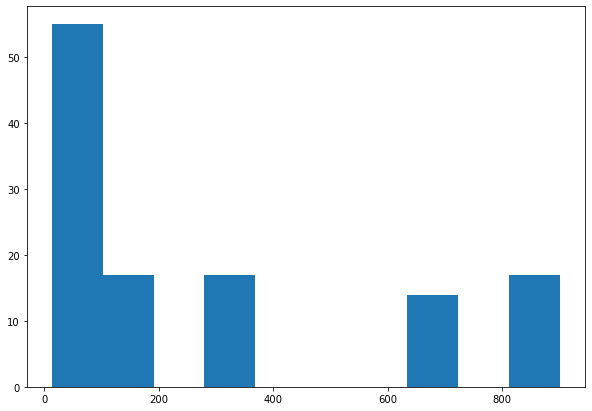

In [67]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df_y_sp50['Train_Len'])
plt.show()

In [68]:
df_y_sp50['Test_Len'].value_counts()

7     54
14    26
28    20
21    20
Name: Test_Len, dtype: int64

So, a pretty clear winner in the test value.

Again, slight edge to 60 days for training, but clearly 7 days is the winner in testing. Let's do this one more time with the Nasdaq.

In [69]:
len(nsdq)

1701

In [70]:
nsdq.head()

Unnamed: 0 Symbol                   Company Name
0           1    AAL  American Airlines Group, Inc.
1           2   AAME  Atlantic American Corporation
2           3   AAOI  Applied Optoelectronics, Inc.
3           4   AAON                     AAON, Inc.
4           5   AAPL                     Apple Inc.

In [72]:
nsdq.loc[nsdq['Symbol']=='AFH']

Empty DataFrame
Columns: [Unnamed: 0, Symbol, Company Name]
Index: []

In [86]:
#nsdq = nsdq.drop(labels=[78], axis=0)

2970 stocks is WAY too many to look through, so let's just do another 50, like we did with the S&P.

I had found a few stocks were missing from my NASDAQ list, so I've written the following code to get rid of all the symbols that had been delisted since I got this data.

In [113]:
#no_data=[]
#for each in nsdq['Symbol']:
#    stock = yf.Ticker(each)
#    df1=stock.history(period='1d')
#    df=df1['Close']
#    if len(df)==0:
#        no_data.append(each)

- AAIT: No data found for this date range, symbol may be delisted
- AAVL: No data found for this date range, symbol may be delisted
- ABAC: No data found for this date range, symbol may be delisted
- ABAX: No data found for this date range, symbol may be delisted
- ABCD: No data found for this date range, symbol may be delisted
- ABCO: No data found for this date range, symbol may be delisted
- ABCW: No data found for this date range, symbol may be delisted
- ABDC: No data found, symbol may be delisted
- ABGB: No data found for this date range, symbol may be delisted
- ABTL: No data found for this date range, symbol may be delisted
- ABY: No data found for this date range, symbol may be delisted
- ACAS: No data found for this date range, symbol may be delisted
- ACAT: No data found for this date range, symbol may be delisted
- ACFC: No data found for this date range, symbol may be delisted
- ACHN: No data found, symbol may be delisted
- ACPW: No data found for this date range, symbol m

- BKYF: No data found for this date range, symbol may be delisted
- BLMT: No data found, symbol may be delisted
- BLVD: No data found for this date range, symbol may be delisted
- BLVDU: No data found for this date range, symbol may be delisted
- BLVDW: No data found, symbol may be delisted
- BNCL: No data found, symbol may be delisted
- BNCN: No data found for this date range, symbol may be delisted
- BOBE: No data found for this date range, symbol may be delisted
- BOFI: No data found for this date range, symbol may be delisted
- BONA: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BOTA: No data found for this date range, symbol may be delisted
- BPFH: No data found for this date range, symbol may be delisted
- BPFHP: No data found, symbol may be delisted
- BPFHW: No data found, symbol may be delisted
- BRCD: No data found for this date range, symbol may be delisted
- BRCM: No data found for this date rang

- CPXX: No data found for this date range, symbol may be delisted
- CRAY: No data found, symbol may be delisted
- CRDC: No data found for this date range, symbol may be delisted
- CRDS: No data found for this date range, symbol may be delisted
- CRDT: No data found for this date range, symbol may be delisted
- CRME: No data found for this date range, symbol may be delisted
- CRRC: No data found for this date range, symbol may be delisted
- CRRS: No data found for this date range, symbol may be delisted
- CRTN: No data found for this date range, symbol may be delisted
- CRWN: No data found for this date range, symbol may be delisted
- CRZO: No data found, symbol may be delisted
- CSBK: No data found for this date range, symbol may be delisted
- CSCD: No data found for this date range, symbol may be delisted
- CSFL: No data found, symbol may be delisted
- CSRE: No data found for this date range, symbol may be delisted
- CSUN: No data found for this date range, symbol may be delisted
- CT

- FBSS: No data found, symbol may be delisted
- FCHI: No data found, symbol may be delisted
- FCLF: No data found for this date range, symbol may be delisted
- FCS: No data found for this date range, symbol may be delisted
- FCSC: No data found, symbol may be delisted
- FCTY: No data found for this date range, symbol may be delisted
- FCVA: No data found for this date range, symbol may be delisted
- FCZA: No data found for this date range, symbol may be delisted
- FCZAP: No data found, symbol may be delisted
- FDEF: No data found, symbol may be delisted
- FDML: No data found for this date range, symbol may be delisted
- FEIC: No data found for this date range, symbol may be delisted
- FES: No data found for this date range, symbol may be delisted
- FFBCW: No data found, symbol may be delisted
- FFKT: No data found for this date range, symbol may be delisted
- FFNM: No data found for this date range, symbol may be delisted
- FHCO: No data found for this date range, symbol may be deliste

- HWAY: No data found for this date range, symbol may be delisted
- HWCC: No data found for this date range, symbol may be delisted
- HYGS: No data found, symbol may be delisted
- HYND: No data found for this date range, symbol may be delisted
- IACI: No data found for this date range, symbol may be delisted
- IBCA: No data found for this date range, symbol may be delisted
- IBKC: No data found, symbol may be delisted
- ICEL: No data found for this date range, symbol may be delisted
- ICLDW: No data found, symbol may be delisted
- IDSA: No data found, symbol may be delisted
- IDSY: No data found, symbol may be delisted
- IDTI: No data found, symbol may be delisted
- IFAS: No data found for this date range, symbol may be delisted
- IFEU: No data found for this date range, symbol may be delisted
- IFNA: No data found, symbol may be delisted
- IFON: No data found for this date range, symbol may be delisted
- IGTE: No data found for this date range, symbol may be delisted
- IIJI: No data f

- MBLX: No data found for this date range, symbol may be delisted
- MBRG: No data found for this date range, symbol may be delisted
- MBTF: No data found, symbol may be delisted
- MBVT: No data found for this date range, symbol may be delisted
- MCEP: No data found, symbol may be delisted
- MCGC: No data found for this date range, symbol may be delisted
- MCOX: No data found for this date range, symbol may be delisted
- MCRL: No data found for this date range, symbol may be delisted
- MCUR: No data found for this date range, symbol may be delisted
- MDAS: No data found for this date range, symbol may be delisted
- MDCO: No data found, symbol may be delisted
- MDM: No data found for this date range, symbol may be delisted
- MDSO: No data found, symbol may be delisted
- MDSY: No data found for this date range, symbol may be delisted
- MDVN: No data found for this date range, symbol may be delisted
- MDVXU: No data found for this date range, symbol may be delisted
- MEET: No data found, s

- OXLCN: No data found, symbol may be delisted
- OXLCO: No data found for this date range, symbol may be delisted
- OZRK: No data found, symbol may be delisted
- PAGG: No data found for this date range, symbol may be delisted
- PARN: No data found for this date range, symbol may be delisted
- PATIV: No data found, symbol may be delisted
- PBCP: No data found for this date range, symbol may be delisted
- PBIB: No data found for this date range, symbol may be delisted
- PBMD: No data found for this date range, symbol may be delisted
- PBSK: No data found for this date range, symbol may be delisted
- PCBK: No data found for this date range, symbol may be delisted
- PCCC: No data found for this date range, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- PCMI: No data found, symbol may be delisted
- PCO: No data found for this date range, symbol may be delisted
- PCYC: No data found for this date range, symbol may be delisted
- PDII: No data found 

- SAEX: No data found, symbol may be delisted
- SAJA: No data found for this date range, symbol may be delisted
- SALE: No data found for this date range, symbol may be delisted
- SANWZ: No data found, symbol may be delisted
- SAPE: No data found for this date range, symbol may be delisted
- SBBX: No data found, symbol may be delisted
- SBCP: No data found for this date range, symbol may be delisted
- SBLKL: No data found, symbol may be delisted
- SBNYW: No data found, symbol may be delisted
- SBRAP: No data found, symbol may be delisted
- SBSA: No data found for this date range, symbol may be delisted
- SCAI: No data found for this date range, symbol may be delisted
- SCLN: No data found for this date range, symbol may be delisted
- SCMP: No data found for this date range, symbol may be delisted
- SCOK: No data found for this date range, symbol may be delisted
- SCSS: No data found for this date range, symbol may be delisted
- SEMI: No data found for this date range, symbol may be del

- TKMR: No data found, symbol may be delisted
- TLF: No data found, symbol may be delisted
- TLMR: No data found for this date range, symbol may be delisted
- TNAV: No data found, symbol may be delisted
- TNGO: No data found for this date range, symbol may be delisted
- TRAK: No data found for this date range, symbol may be delisted
- TRCB: No data found, symbol may be delisted
- TRCH: No data found for this date range, symbol may be delisted
- TRGT: No data found for this date range, symbol may be delisted
- TRIV: No data found for this date range, symbol may be delisted
- TROV: No data found, symbol may be delisted
- TROVU: No data found, symbol may be delisted
- TROVW: No data found, symbol may be delisted
- TRTL: No data found for this date range, symbol may be delisted
- TRTLU: No data found for this date range, symbol may be delisted
- TRTLW: No data found, symbol may be delisted
- TSRA: No data found for this date range, symbol may be delisted
- TSRE: No data found for this date

- ZIONW: No data found, symbol may be delisted
- ZIONZ: No data found, symbol may be delisted
- ZIV: No data found for this date range, symbol may be delisted
- ZLTQ: No data found for this date range, symbol may be delisted
- ZN: No data found, symbol may be delisted
- ZSPH: No data found, symbol may be delisted
- ZU: No data found, symbol may be delisted


In [114]:
#len(no_data)

1265

In [115]:
#no_data[4:8]

['ABCD', 'ABCO', 'ABCW', 'ABDC']

In [116]:
#y=nsdq.loc[nsdq['Symbol']==no_data[4]].index

In [117]:
#y[0]

12

In [118]:
#nd_index=[]
#for each in no_data:
#    y=nsdq.loc[nsdq['Symbol']==each].index
#    nd_index.append(y[0])

In [119]:
#len(nd_index)

1265

In [120]:
#nsdq = nsdq.drop(labels=nd_index, axis=0)

In [73]:
nsdq.reset_index(drop=True,inplace=True)

In [127]:
#nsdq.to_csv('Data/nasdaq.csv',index=True)

Just to be safe, let's do the same thing with the S&P data.

In [74]:
no_data_sp=[]
for each in sp_500['Symbol']:
    stock = yf.Ticker(each)
    df1=stock.history(period='1d')
    df=df1['Close']
    if len(df)==0:
        no_data_sp.append(each)

- ALXN: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [75]:
no_data_sp

['ALXN', 'BRK.B', 'BF.B']

In [76]:
sp_500.loc[sp_500['Symbol']==no_data_sp[1]].index

Int64Index([64], dtype='int64')

In [77]:
sp_500.loc[sp_500['Symbol']==no_data_sp[0]].index

Int64Index([18], dtype='int64')

In [78]:
sp_500.loc[sp_500['Symbol']==no_data_sp[2]].index

Int64Index([78], dtype='int64')

In [79]:
sp_500 = sp_500.drop(labels=[18,64,78], axis=0)

In [80]:
sp_500.to_csv('Data/constituents_csv.csv',index=True)

In [81]:
sp_500.reset_index(drop=True,inplace=True)

In [82]:
sp_500.head()

Symbol                 Name                  Sector
0    MMM                   3M             Industrials
1    ABT  Abbott Laboratories             Health Care
2   ABBV               AbbVie             Health Care
3   ABMD              Abiomed             Health Care
4    ACN            Accenture  Information Technology

In [83]:
picks=[]
for i in range (0,25):
    x = random.randint(0,(len(nsdq)-1))
    picks.append(x)

In [84]:
nsdq.reset_index(drop=True,inplace=True)


In [85]:
nsdq.head()

Unnamed: 0 Symbol                   Company Name
0           1    AAL  American Airlines Group, Inc.
1           2   AAME  Atlantic American Corporation
2           3   AAOI  Applied Optoelectronics, Inc.
3           4   AAON                     AAON, Inc.
4           5   AAPL                     Apple Inc.

In [87]:
nsdq.drop(columns='Unnamed: 0',inplace=True)

In [88]:
len(nsdq)

1701

In [89]:
tests=[7,14,21,28]

In [90]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in nsdq['Symbol'][picks]:
    stock_res_nd50 = tt_test(each,trains,tests)
    print (stock_res_nd50[(stock_res_nd50.MAE == stock_res_nd50.MAE.min())])
for each in stock_res_nd50.index:
    stock_res_nd50['Symbol'][each]=str(stock_res_nd50['Symbol'][each])
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].replace('>','')
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_nd50.columns)
df_y_nd50=df_x.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <MCBK>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7.788, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11.190, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6.017, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6.392, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=139.321, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6.104, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7.038, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9.345, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.804 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.118, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.847, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   :

 ARIMA(1,1,3)(0,0,0)[0]             : AIC=578.919, Time=0.11 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.840 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=922.292, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=974.638, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=972.319, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=963.302, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=972.845, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=920.318, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=918.343, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=920.317, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=936.128, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=922.340, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=917.655, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=961.798, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]            

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1311.054, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1412.307, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1406.569, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1390.631, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1410.946, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1309.092, Time=0.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1307.096, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1309.091, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1337.682, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1311.029, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1309.106, Time=0.05 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.465 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=29.529, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28.003, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] in

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=184.578, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=187.010, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.178 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=607.761, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=609.539, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=609.554, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=607.350, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=611.172, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.518 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1204.195, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1199.436, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1201.192, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1201

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3917.739, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.742 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=37.033, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.071, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=41.327, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=42.108, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=150.527, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=43.164, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=45.493, Time=0.20 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=41.314, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=43.274, Time=0.11 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=40.498, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=606.569, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=608.558, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=608.559, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=605.489, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=609.677, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.574 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1215.744, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1211.245, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1212.223, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1212.360, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1209.248, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1212.508, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.426 seconds
Performing stepwise s

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=516.521, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=516.177, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=458.404, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=454.843, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=498.072, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=456.277, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=456.825, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=455.160, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=458.838, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=452.882, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=496.111, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=454.312, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=454.865, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=454.846, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=512.513, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]  

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=437.793, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 1.951 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=453.889, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=515.356, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=511.453, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=513.614, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=513.449, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=455.382, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=451.926, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=494.967, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=453.498, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=453.909, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=452.281, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=455.923, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0]            

 ARIMA(5,1,2)(0,0,0)[0]             : AIC=414.668, Time=0.62 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=435.649, Time=0.17 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=413.081, Time=0.65 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=423.134, Time=0.35 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=408.614, Time=0.62 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=417.405, Time=0.55 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=408.279, Time=1.27 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=411.118, Time=0.84 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=410.255, Time=1.65 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 9.608 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=452.257, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=513.283, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=509.081, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=511.343, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]            

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=425.110, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=438.912, Time=0.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=424.508, Time=0.58 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=412.885, Time=1.08 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=408.368, Time=0.98 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=418.465, Time=1.04 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=408.224, Time=1.79 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=410.824, Time=1.28 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=406.346, Time=1.20 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=408.946, Time=0.85 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=406.494, Time=0.69 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=416.584, Time=0.67 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 14.894 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-83.549, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-88.329, Time=0.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-84.286, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-86.549, Time=0.70 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-86.416, Time=0.50 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-85.587, Time=0.68 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-89.706, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-85.822, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-87.943, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.67 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-87.721, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-84.948, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-87.510, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0]             :

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-288.053, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-260.761, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-287.896, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-287.895, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-286.155, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-291.362, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-289.364, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-289.363, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-289.497, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-287.656, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.570 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-400.157, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-371.546, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-397.768, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-292.256, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-286.908, Time=0.31 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-290.575, Time=1.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-290.559, Time=1.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-291.814, Time=1.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-286.089, Time=0.47 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-293.771, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-292.765, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-288.451, Time=0.24 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-292.109, Time=0.57 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-292.089, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-288.619, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-293.334, Time=0.45 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-287.650, Time=0.18 sec
 ARIMA(4,1,3)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-293.516, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-262.673, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-291.341, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-289.452, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-264.448, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-289.957, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-287.864, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-293.997, Time=0.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-288.123, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-292.375, Time=1.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-292.355, Time=1.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-293.782, Time=0.76 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-287.513, Time=0.45 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-295.687, Time=0.45 sec
 ARIMA(2,1,2)(0

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=262.972, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=253.853, Time=0.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=264.418, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=257.628, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=253.902, Time=0.13 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.039 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-34.012, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-21.078, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-27.579, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-25.088, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=61.887, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-25.438, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-29.627, Time=0.38 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AI

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-128.357, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.658 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-232.132, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-236.846, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-236.388, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-236.722, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-238.588, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-235.718, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.464 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-620.651, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-625.621, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-624.877, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : A

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=284.457, Time=0.76 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=280.114, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=285.686, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=286.029, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=281.271, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=281.693, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=285.052, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=283.734, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=287.757, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 5.856 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
118  yfinance.Ticker object <TENX>       900        7 -0.648103  0.04483   

         RMSE        R2  
118  0.055982 -3.594412  
Processing:  yfinance.Ticker object <RDI>
Performing stepwise search to 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-62.493, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-60.833, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-60.843, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-64.433, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-58.844, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.349 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-39.699, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-38.670, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-42.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-41.638, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-38.714, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-40.729, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-40.535, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : A

 ARIMA(3,2,2)(0,0,0)[0]             : AIC=5.171, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.524 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-180.130, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-181.766, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-181.028, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-180.900, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-181.145, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-183.989, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-181.989, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-181.989, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-181.188, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-181.289, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-184.945, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]       

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-259.656, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-261.399, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-259.550, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-259.536, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-261.630, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-262.245, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-258.034, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-257.977, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-259.877, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-259.900, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-263.535, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-259.811, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-259.830, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-258.451, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-258.389, Time=0.26 sec
 ARIMA(0,1

 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3757.937, Time=1.96 sec

Best model:  ARIMA(5,1,3)(0,0,0)[0]          
Total fit time: 11.899 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=61.868, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=57.534, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=57.285, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.850, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=58.521, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=58.365, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=60.384, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.635 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=143.086, Time=0.01 

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=799.842, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=800.191, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.484 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1748.880, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1748.908, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1750.906, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1750.906, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1747.344, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1752.901, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.543 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3134.819, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3138.774, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3140.330, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3755.459, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3755.893, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3752.542, Time=0.69 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3752.237, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3757.705, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3753.050, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3755.118, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3750.982, Time=0.99 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3750.564, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3755.237, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3755.651, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3752.550, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3752.050, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3758.055, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3753.198, Time=0.18 sec
 ARIMA(3,1

 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=-58.628, Time=3.31 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=-58.798, Time=3.44 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=-48.347, Time=1.65 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=-46.345, Time=2.56 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-62.212, Time=2.27 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=-49.315, Time=1.11 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-57.533, Time=1.17 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=-60.177, Time=2.59 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=-59.931, Time=2.19 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-48.367, Time=0.45 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=-49.912, Time=0.94 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-48.966, Time=0.72 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=-47.891, Time=1.94 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 41.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16.535, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18.513, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18.515, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15.089, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20.047, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.244 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13.267, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5.898, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7.637, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7.626, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4.314, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9.596, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.319 seconds


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6.035, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8.243, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4.044, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.254 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=113.880, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=114.970, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=111.111, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=110.579, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=114.238, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=110.692, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=111.904, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=112.641, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=110.576, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=111.465, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : 

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=141.783, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=139.367, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=138.513, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=140.775, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=139.572, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=142.460, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=135.149, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=139.782, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=138.018, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=137.051, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=139.388, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=138.220, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=141.092, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]          

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=36.515, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=38.135, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=40.114, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=34.673, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=43.479, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=36.308, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=36.281, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=37.566, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=38.280, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.863 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=141.011, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=153.786, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=149.186, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=150.752, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31.880, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=31.287, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=29.928, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=30.190, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30.635, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29.150, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=30.447, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=31.875, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=28.327, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=31.058, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=29.931, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=29.492, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=29.299, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=30.411, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=28.615, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AI

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=120.565, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=120.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.520, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=119.426, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=120.279, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=234.051, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=237.227, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=237.296, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=237.536, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=235.404, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=237.854, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=237.940, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : A

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=307.526, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=308.255, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=308.232, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=316.200, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=310.743, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=307.987, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=310.184, Time=0.37 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.481 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2227.607, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2020.276, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=1900.931, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1813.127, Time=0.07 sec
 ARIMA(4,2,0)(0,0,0)[0]             : A

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2571.530, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2571.919, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2558.187, Time=0.80 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2558.114, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2572.555, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2563.670, Time=1.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2568.024, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2556.380, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2571.721, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2572.142, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2557.617, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2557.543, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2572.748, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2574.666, Time=0.15 sec
 ARIMA(3,1,1)(0

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=0.610, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.412 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20.919, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21.072, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26.484, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24.375, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20.933, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-24.738, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24.689, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-22.808, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-23.211, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.378 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7.001, Ti

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=209.400, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.477 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=711.191, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=718.550, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=716.917, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=717.090, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=716.573, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=720.279, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=720.478, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=712.861, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=712.775, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=718.915, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=712.972, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : A

 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=239.107, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=592.721, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=222.651, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=224.160, Time=0.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=218.785, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=216.943, Time=0.16 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=224.042, Time=0.04 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=218.839, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=236.614, Time=0.03 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=220.066, Time=0.06 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=228.190, Time=0.06 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0] intercept
Total fit time: 1.614 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=89.080, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.785 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=282.397, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=224.271, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=247.488, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=591.464, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=225.334, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=225.473, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=227.332, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.567 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=717.803, Time=0.

 ARIMA(1,1,2)(0,0,0)[0]             : AIC=97.192, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.280 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=286.984, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=228.126, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=250.964, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=592.238, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=229.729, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=229.796, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=231.713, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.347 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=734.241, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=734.509, Tim

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1478.377, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1477.962, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1475.598, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1476.254, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1476.234, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1474.835, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1476.755, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1476.802, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1475.776, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1473.738, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1475.467, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1475.556, Time=0.46 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1477.207, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1476.593, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0]          

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2595.550, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2589.451, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2590.608, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2594.539, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2586.652, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2588.198, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2588.458, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2587.834, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2584.490, Time=0.42 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2586.397, Time=0.51 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2586.438, Time=0.48 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2587.759, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2587.119, Time=0.74 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2585.055, Time=0.16 sec

Best model:  A

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3049.505, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3048.759, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3044.256, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3046.191, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3046.218, Time=0.82 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3047.891, Time=0.12 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3046.567, Time=1.05 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3047.152, Time=0.19 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 5.185 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=49.953, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=43.465, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47.080, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=166.139, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept 

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=153.893, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=155.460, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=155.529, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=152.096, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=157.409, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.266 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=331.668, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=388.218, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=329.159, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=356.037, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=743.199, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=331.072, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=331.088, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=332.742, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]            

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=72.513, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=69.707, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=71.075, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=173.870, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=72.393, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=71.486, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.803 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=148.433, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=150.433, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=150.433, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=146.636, Time=

Processing:  yfinance.Ticker object <CZWI>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-20.505, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-26.515, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-25.107, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-25.106, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=114.855, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-23.107, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.423 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-35.062, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-45.761, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-42.863, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=244.156, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-43.943, Time=0.10 sec
 ARIMA(1,0,1)(0,0,

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=27.740, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=68.814, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24.217, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=45.765, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=484.868, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=24.178, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=25.781, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=25.796, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24.633, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=27.801, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.883 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8.930, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6.040, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.757,

 ARIMA(1,2,2)(0,0,0)[0]             : AIC=21.714, Time=0.17 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=17.864, Time=0.10 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=17.814, Time=0.29 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=10.671, Time=0.32 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=17.206, Time=0.26 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=12.138, Time=0.83 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=12.194, Time=0.38 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=19.639, Time=0.39 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=inf, Time=1.15 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.64 sec

Best model:  ARIMA(2,2,3)(0,0,0)[0]          
Total fit time: 4.904 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.81 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=465.281, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=141.223, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.1

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-167.488, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-160.836, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-169.193, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-160.209, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-165.597, Time=0.34 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 5.381 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-303.489, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-327.663, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-324.833, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-305.483, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-327.125, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-326.763, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-114.784, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.090, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.327, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-116.178, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.514 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13.431, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10.580, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12.488, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12.464, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9.225, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13.376, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.440 seconds
Performing stepwise search to mini

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-50.876, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49.270, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-49.796, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-52.687, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.482 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-67.244, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-64.897, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.763, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-70.294, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-66.890, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-71.193, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-69.273, Time=0.12 sec


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=903.572, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=933.808, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=898.649, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=899.709, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=931.818, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=900.352, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=900.332, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=901.607, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=896.668, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=898.372, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=898.353, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=897.733, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=899.637, Time=0.09 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.866 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept  

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=39.071, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=35.100, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28.235, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=32.777, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=139.250, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.519, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29.842, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=31.074, Time=0.21 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.038 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=56.907, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=74.924, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=54.064, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=65.910, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=295.462,

 ARIMA(2,2,1)(0,0,0)[0]             : AIC=901.579, Time=0.08 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=895.981, Time=0.20 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=891.781, Time=0.24 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=900.973, Time=0.29 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=889.727, Time=0.28 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=889.898, Time=0.28 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=886.569, Time=0.62 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=888.611, Time=0.32 sec
 ARIMA(4,2,4)(0,0,0)[0]             : AIC=888.418, Time=0.87 sec
 ARIMA(3,2,5)(0,0,0)[0]             : AIC=inf, Time=1.42 sec
 ARIMA(2,2,5)(0,0,0)[0]             : AIC=889.048, Time=0.61 sec
 ARIMA(4,2,5)(0,0,0)[0]             : AIC=inf, Time=1.50 sec
 ARIMA(3,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec

Best model:  ARIMA(3,2,4)(0,0,0)[0]          
Total fit time: 8.366 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1619.

 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1104.164, Time=0.30 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 8.113 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1902.666, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2003.328, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1944.079, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1952.551, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2001.377, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1941.682, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1942.088, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1916.120, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1920.032, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1940.319, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1921.840, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1932.004, Time=0.20 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1128.415, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1105.616, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1126.471, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1119.727, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1126.221, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1105.031, Time=0.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1106.839, Time=0.88 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1106.147, Time=0.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1104.553, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=1106.055, Time=0.37 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=1111.748, Time=0.21 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1108.014, Time=0.61 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1102.588, Time=0.18 sec
 ARIMA(1,1,4)(0,0,0)

 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=386.392, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=384.578, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=389.564, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=387.555, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.996 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1103.482, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1176.881, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1126.565, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1135.738, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1174.898, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1127.193, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1127.365, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1110.815, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] interce

 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=84.013, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=84.427, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=86.060, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.091 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=383.491, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=383.859, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=382.966, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=383.832, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=377.154, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=378.419, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=377.957, Tim

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-15.227, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.831, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.385, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-17.520, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-13.248, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-17.237, Time=0.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-16.885, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13.229, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-18.271, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-20.186, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-15.521, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-18.322, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-16.394, Time=0.16 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-21.159, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-17.093, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]  

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=307.740, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=306.761, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=308.635, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=311.476, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=309.740, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=305.779, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=316.216, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=306.852, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=307.694, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=310.869, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=308.849, Time=0.12 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.373 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=317.664, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=329.181, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept  

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=316.966, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=312.677, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=325.607, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=314.124, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=314.643, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=320.084, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=316.069, Time=0.27 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 2.505 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=408.782, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=414.135, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=411.656, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=412.410, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=413.327, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=406.876, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept  

 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=391.908, Time=0.81 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=359.244, Time=1.44 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=357.485, Time=0.60 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=390.975, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=367.994, Time=0.62 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=358.413, Time=0.75 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=397.643, Time=0.38 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=371.050, Time=0.96 sec

Best model:  ARIMA(2,1,5)(0,0,0)[0]          
Total fit time: 14.358 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
118  yfinance.Ticker object <TENX>       900        7 -0.648103  0.04483   

         RMSE        R2  
118  0.055982 -3.594412  
Processing:  yfinance.Ticker object <NTGR>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3.737, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.567

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1002.556, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1000.907, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=997.728, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=997.262, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=999.294, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=998.595, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=998.763, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1000.582, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=995.789, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=997.202, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=997.338, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=996.225, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=999.196, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.878 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercep

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=524.507, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.257 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=999.696, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=998.639, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=995.011, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=994.468, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=997.444, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=995.802, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=995.921, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=997.802, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=993.541, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=994.984, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=995.071, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=994.029, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]            

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-152.461, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-148.463, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-149.186, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-154.458, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-151.626, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-152.202, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-153.154, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-153.199, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-150.458, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-151.181, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-153.866, Time=0.42 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 6.001 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1.179, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] interc

 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-18.264, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-18.167, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-19.479, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-16.024, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-16.801, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-15.737, Time=0.22 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6.719, Time=0.09 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.824 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11.018, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14.014, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14.871, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14.689, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.141, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AI

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=133.456, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.216 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-68.236, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-59.650, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-66.931, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-66.404, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-61.388, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-63.151, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-66.793, Time=0.77 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-66.280, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-66.279, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-68.213, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-65.535, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-65.447, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1634.685, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1648.841, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1637.994, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1640.453, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1647.181, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1633.526, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1630.973, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1632.941, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1632.082, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1627.386, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1621.110, Time=0.89 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1620.636, Time=1.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1619.433, Time=0.97 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1634.860, Time=0.10 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1627.183, Time=1.06 sec
 ARIMA(2,1

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1653.605, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1640.501, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1638.544, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1640.497, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1639.854, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1642.544, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1636.679, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1646.123, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1638.633, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1638.628, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1638.015, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1640.679, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 1.704 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1953.863, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1953.182, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1969.831, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1958.335, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1960.845, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1967.833, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1951.828, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1949.831, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1951.831, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1950.726, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1945.553, Time=0.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1940.569, Time=1.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1938.884, Time=1.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1954.777, Time=0.65 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1942.518, Time=1.23 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1940.546, Time=2.21 sec
 ARIMA(2,1

 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=1937.019, Time=2.08 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.36 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=1939.017, Time=2.45 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=1928.363, Time=3.37 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=1938.011, Time=1.35 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=1926.273, Time=1.63 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=1936.013, Time=0.57 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1936.882, Time=1.42 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=1937.019, Time=1.06 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1939.138, Time=0.82 sec
 ARIMA(5,1,4)(0,0,0)[0]             : AIC=1935.021, Time=1.00 sec

Best model:  ARIMA(4,1,5)(0,0,0)[0]          
Total fit time: 33.726 seconds
                            Symbol Train_Len Test_Len   Exp_var      MAE  \
118  yfinance.Ticker object <TENX>       900        7 -0.648103  0.04483   

         RMSE        R2  
118  0.055982 -3.59441

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=61.731, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=63.645, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=63.659, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=62.755, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=65.588, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.711 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=142.502, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=136.029, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=138.028, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=138.028, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=134.240, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=140.028, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.693 seconds
Performing stepwise search to mi

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36.090, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.227, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37.326, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36.985, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=39.211, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.452 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17.648, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.348, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15.670, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21.291, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17.293, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17.320, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18.549, Time

 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-133.878, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-132.429, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-135.498, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.497 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-99.657, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-100.192, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-99.920, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-101.627, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-99.356, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.994 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-157.308, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-144.416, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-151.084, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-149.231, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-149.123, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-153.586, Time=1.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-153.593, Time=1.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-150.972, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-153.612, Time=0.44 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-152.799, Time=0.63 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-162.918, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-151.127, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-151.017, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-155.478, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-155.482, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-152.862, Time=0.09 sec
 ARIMA(1,1,3)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-155.271, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-159.745, Time=1.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-159.745, Time=1.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-157.112, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-159.657, Time=0.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-158.869, Time=0.60 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-164.640, Time=1.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-169.073, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-157.247, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-157.132, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-161.604, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-161.602, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-158.969, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-161.426, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-160.638, Time=0.27 sec
 ARIMA(3,1

 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-160.810, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-169.313, Time=1.07 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 11.198 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-374.106, Time=1.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-359.060, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-363.149, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-362.819, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-360.831, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-359.907, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-359.790, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-366.651, Time=1.28 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-361.620, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-365.119, Time=0.61 sec
 ARIMA(3,1,1)(0,0,0)[0] in

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=209.135, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=209.992, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=209.574, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=207.224, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.393 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=694.411, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=695.312, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=695.354, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=692.598, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=697.058, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.620 seconds
Performing stepwise search to minim

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=47.025, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.456 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=111.385, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=96.500, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=98.298, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=362.060, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=98.252, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=97.862, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=100.467, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.704 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=204.974, Time=0.12 s

 ARIMA(2,1,4)(0,0,0)[0]             : AIC=321.389, Time=0.27 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 3.375 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=522.708, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=528.848, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=530.337, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=530.428, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=526.902, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=522.929, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=524.309, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=524.215, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=523.788, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=531.374, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=521.808, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=521.919, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept  

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=564.214, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=560.542, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=558.060, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=559.259, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=559.471, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=559.238, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=565.218, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=557.238, Time=0.33 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=557.552, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=561.215, Time=0.59 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=554.901, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=556.060, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=557.259, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=557.472, Time=0.24 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=557.238, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]  

 ARIMA(0,1,3)(0,0,0)[0]             : AIC=551.393, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=552.209, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=553.110, Time=0.25 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=553.110, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=551.500, Time=0.06 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=552.637, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=553.698, Time=0.15 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=555.110, Time=0.25 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 4.499 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=724.497, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=725.403, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=727.270, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=727.290, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=723.427, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept  

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [91]:
1400/25

28.0

In [92]:
a=0
b=len(stock_res_nd50)
while a<=(b-28):
    df_x=stock_res_nd50.loc[stock_res_nd50.index[a:(a+28)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_nd50=pd.concat([df_y_nd50,df_ph])
    a+=28

In [93]:
stock_res_nd50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Symbol     700 non-null    object 
 1   Train_Len  700 non-null    object 
 2   Test_Len   700 non-null    object 
 3   Exp_var    700 non-null    float64
 4   MAE        700 non-null    float64
 5   RMSE       700 non-null    float64
 6   R2         700 non-null    float64
dtypes: float64(4), object(3)
memory usage: 63.8+ KB


In [94]:
df_y_nd50['Test_Len'].value_counts()

7     34
14    21
21    14
28     6
Name: Test_Len, dtype: int64

In [95]:
df_y_nd50['Train_Len'].value_counts()

180    20
720    12
14     11
900    11
360     9
60      8
30      4
Name: Train_Len, dtype: int64

Still no clear winner in the training length. But test length is definitely going to be 7 days. What if there is some correlation between the test length and training length? Let's run through these indices again, but this time with just 7 days as our test length.

In [96]:
tests=[7]

In [97]:
cols2=['Symbol','Train_Len','Test_Len','Exp_var','MAE','RMSE','R2']
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in dow_30['Symbol']:
    stock_res_d30 = tt_test(each,trains,tests)
    print (stock_res_d30[(stock_res_d30.MAE == stock_res_d30.MAE.min())])
for each in stock_res_d30.index:
    stock_res_d30['Symbol'][each]=str(stock_res_d30['Symbol'][each])
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].replace('>','')
    stock_res_d30['Symbol'][each]=stock_res_d30['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_d30.columns)
df_y_d30=df_x.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <MMM>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=57.175, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=53.265, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=57.047, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=54.973, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=54.915, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55.996, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.429 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=136.682, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168.781, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=132.206, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3374.299, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3391.508, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3387.750, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3388.382, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3390.560, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3388.306, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3388.528, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3386.578, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3387.372, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3384.954, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3387.867, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3372.163, Time=0.87 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3371.751, Time=1.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : 

 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4783.798, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4783.315, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4785.288, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4781.105, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=4782.638, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4782.146, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4781.726, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4784.126, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.296 seconds
                         Symbol Train_Len Test_Len   Exp_var       MAE  \
2  yfinance.Ticker object <MMM>        60        7  0.122077  1.268467   

       RMSE        R2  
2  1.807821 -0.502823  
Processing:  yfinance.Ticker object <AAPL>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=48.839, T

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1918.327, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1928.219, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1929.787, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1930.683, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1921.728, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1917.504, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1928.236, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1928.682, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1917.800, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1927.909, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1929.458, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1930.345, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=0.73 sec

Best model:  ARIMA(2,1,2

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1668.725, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1667.164, Time=0.49 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1667.943, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1685.567, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=1677.712, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1667.136, Time=0.13 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=1670.619, Time=0.14 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 5.028 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3042.675, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3080.043, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3071.954, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3073.718, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3078.045, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3066.996, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1765.532, Time=1.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1762.846, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1766.820, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1766.834, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1770.801, Time=0.32 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1750.179, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1763.117, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1763.126, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=1.07 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1763.829, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1761.137, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1765.109, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1765.122, Time=0.06 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1769.092, Time=0.23 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 6.861 seconds
Perf

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1964.634, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1964.567, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1964.833, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1963.275, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1965.754, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.689 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3551.119, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3580.324, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3578.899, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3579.274, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3579.463, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3566.523, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3580.343, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] int

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2401.256, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2443.801, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2405.217, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2412.537, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2441.911, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2399.949, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2398.470, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2399.687, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2405.104, Time=0.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2395.472, Time=0.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2397.227, Time=0.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2397.316, Time=0.52 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2401.116, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2393.599, Time=0.23 sec
 ARIMA(0,1,3)(0

 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3184.539, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3184.533, Time=0.88 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3209.691, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3212.304, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3212.654, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3180.951, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3208.546, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3208.717, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3182.588, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3182.581, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3207.741, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=3210.351, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3210.700, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.64 sec

Best model:  ARIMA(

 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2973.956, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2967.029, Time=0.74 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2963.902, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2980.735, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2971.130, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2964.966, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2964.192, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2982.329, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2975.683, Time=0.25 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=2973.079, Time=0.07 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=2966.152, Time=0.44 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 6.181 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3652.583, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3662.348, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3205.960, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3209.848, Time=0.29 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=3185.985, Time=0.86 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3210.321, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=3187.567, Time=0.78 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3184.265, Time=0.23 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=3187.757, Time=0.55 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 9.543 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3887.474, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3916.423, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3899.758, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3903.084, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3915.338, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3891.871, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0

 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3556.062, Time=0.48 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=3542.632, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3585.510, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=3554.957, Time=0.16 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=3558.629, Time=0.24 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=3544.287, Time=0.63 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3587.703, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=3542.632, Time=0.37 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=3555.440, Time=0.21 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=3546.279, Time=0.87 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 14.039 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4369.459, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4397.827, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] in

 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2087.161, Time=2.08 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=2088.352, Time=1.68 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2092.157, Time=0.97 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2104.871, Time=0.74 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2090.225, Time=0.54 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0] intercept
Total fit time: 13.577 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2486.802, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2567.844, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2541.743, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2546.040, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2566.800, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2538.968, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] interce

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=303.222, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=304.978, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.146 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=843.540, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=845.209, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=845.260, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=842.547, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=844.981, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.510 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1692.857, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1694.183, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1694.266,

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5133.396, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5133.298, Time=0.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5123.115, Time=2.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5114.565, Time=0.55 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 8.157 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
101  yfinance.Ticker object <MRK>       180        7  0.289768  0.502066   

         RMSE        R2  
101  0.589213  0.264453  
Processing:  yfinance.Ticker object <BA>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=78.486, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=80.177, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=79.857, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=79.113, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=81.722, Tim

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=940.378, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=940.164, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=940.621, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=938.379, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=934.789, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=937.840, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=931.915, Time=0.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=916.198, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=926.490, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=933.373, Time=0.32 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=916.222, Time=0.96 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=914.474, Time=0.27 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=930.391, Time=0.10 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=916.237, Time=0.22 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=931.662, Time=0.07 sec
 ARIMA(0,1,5)(0,0,0)[0] i

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2279.693, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2289.601, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2285.658, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2286.836, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2289.299, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2283.795, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2284.263, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2281.243, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2287.795, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2284.257, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2285.301, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2285.966, Time=0.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2285.217, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2279.691, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2283.513, Time=0.05 sec
 ARIMA(2,1

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4909.157, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4931.625, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4921.114, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4923.752, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4931.445, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4908.183, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4906.615, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4907.967, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4916.678, Time=0.17 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4909.301, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=4906.301, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4923.977, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=4907.924, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=4907.750, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4916.894, Time=0.06 sec
 ARIMA(1,1

Processing:  yfinance.Ticker object <TRV>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=64.156, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=60.097, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=60.973, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=61.357, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=182.294, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=62.278, Time=0.19 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.546 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=128.623, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=129.834, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=129.605, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=126.805, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=131.522, Time=0.03 sec

Best model:  ARIMA(0,1,

Processing:  yfinance.Ticker object <DIS>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=75.118, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=80.723, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=73.123, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.745, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=70.848, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=73.783, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=76.124, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=72.272, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=75.031, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.017 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=128.911, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] interce

 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=330.875, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.446 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1079.957, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1079.681, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1078.186, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1077.599, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1079.790, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1079.213, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1079.019, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1077.160, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1078.881, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1078.791, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]          

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=777.368, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=799.358, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=780.791, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=784.504, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=797.358, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=780.023, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=781.436, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=776.407, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=780.958, Time=0.25 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=770.102, Time=0.25 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=773.885, Time=0.15 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=771.641, Time=0.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=769.932, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=777.912, Time=0.37 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=767.9

 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2026.650, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2022.444, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2043.776, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2021.623, Time=0.16 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2039.179, Time=0.13 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=2028.320, Time=0.25 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 4.801 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3729.151, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3792.559, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3766.926, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3770.590, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3791.799, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3767.372, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3768.258, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=103.211, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=104.993, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.649 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=201.196, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=244.848, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=198.759, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=219.192, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=765.055, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=199.413, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=199.733, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=201.360, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.588 seconds
Performing stepwise search to m

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
stock_res_d30.head(14)

Symbol Train_Len Test_Len   Exp_var       MAE      RMSE         R2
0     MMM        14        7 -1.527278  4.522738  4.903086 -10.054422
1     MMM        30        7  0.109295  1.742471  2.200984  -1.227567
2     MMM        60        7  0.122077  1.268467  1.807821  -0.502823
3     MMM       180        7 -0.016990  3.115064  3.451853  -4.479005
4     MMM       360        7  0.108944  2.044693  2.433342  -1.722723
5     MMM       720        7  0.000000  2.830715  3.191812  -3.684591
6     MMM       900        7  0.000000  2.830715  3.191812  -3.684591
7     AXP        14        7 -0.077585  2.716503  3.525871  -0.077609
8     AXP        30        7  0.000000  2.700006  4.102008  -0.458550
9     AXP        60        7  0.082892  4.184591  5.300090  -1.434977
10    AXP       180        7 -0.153000  4.722948  5.967223  -2.086548
11    AXP       360        7  0.000000  2.700006  4.102008  -0.458550
12    AXP       720        7  0.016514  2.775771  3.966898  -0.364051
13    AXP       900        7  0.018703  2.752636  3.931237  -0.339637

In [99]:
len(stock_res_d30)

210

In [100]:
df_y_d30=pd.DataFrame(columns=stock_res_d30.columns)

In [101]:
a=0
b=len(stock_res_d30)
while a<=(b-7):
    df_x=stock_res_d30.loc[stock_res_d30.index[a:(a+7)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_d30=pd.concat([df_y_d30,df_ph])
    a+=7

In [102]:
df_y_d30

Symbol Train_Len Test_Len       Exp_var       MAE      RMSE        R2
2      MMM        60        7  1.220771e-01  1.268467  1.807821 -0.502823
1      MMM        30        7  1.092953e-01  1.742471  2.200984 -1.227567
4      MMM       360        7  1.089438e-01  2.044693  2.433342 -1.722723
8      AXP        30        7  0.000000e+00  2.700006  4.102008 -0.458550
11     AXP       360        7  0.000000e+00  2.700006  4.102008 -0.458550
..     ...       ...      ...           ...       ...       ...       ...
197    WBA        30        7  0.000000e+00  0.645244  0.735737 -3.331504
198    WBA        60        7  0.000000e+00  0.645244  0.735737 -3.331504
206    WMT       180        7  3.330669e-16  0.323571  0.405996 -0.011650
209    WMT       900        7 -2.427866e-03  0.344178  0.440091 -0.188697
208    WMT       720        7 -2.960771e-03  0.346331  0.445349 -0.217269

[90 rows x 7 columns]

In [103]:
df_y_d30['Train_Len'].value_counts()

360    18
720    18
30     14
14     12
900    12
180    11
60      5
Name: Train_Len, dtype: int64

Again, unfortunately there is no clear leader in training length. Let's try again with the S&P

In [104]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in sp_500['Symbol'][picks_sp50]:
    stock_res_sp50 = tt_test(each,trains,tests)
    print (stock_res_sp50[(stock_res_sp50.MAE == stock_res_sp50.MAE.min())])
for each in stock_res_sp50.index:
    stock_res_sp50['Symbol'][each]=str(stock_res_sp50['Symbol'][each])
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].replace('>','')
    stock_res_sp50['Symbol'][each]=stock_res_sp50['Symbol'][each].split('<', 1)[-1]
df_x_sp50=pd.DataFrame(columns=stock_res_sp50.columns)
df_y_sp50=df_x_sp50.sort_values(by=['MAE']).head(3)

Processing:  yfinance.Ticker object <PEP>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=39.801, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41.655, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41.604, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=43.127, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.570, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.353 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=96.344, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=97.702, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=97.686, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=95.647, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=99.685, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=228.639, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=230.419, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=230.327, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=227.197, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=231.117, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.243 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=681.082, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=682.155, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=681.915, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=681.280, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=680.391, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=681.819, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.403 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=161

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=753.348, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=751.053, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=749.133, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=750.976, Time=0.05 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=747.538, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=749.071, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=749.478, Time=0.03 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=749.417, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=748.698, Time=0.04 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=750.995, Time=0.18 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0]          
Total fit time: 1.572 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1611.759, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1614.305, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   :

 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=705.134, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=705.134, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=701.611, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=705.823, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.451 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1432.823, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1428.214, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1429.843, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1429.863, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1429.417, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1431.569, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.322 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1850.341, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : 

Processing:  yfinance.Ticker object <J>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=57.988, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=53.749, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=54.913, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=52.871, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=178.809, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=53.433, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.570 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=125.759, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.668, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=125.626, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=186.101, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=188.006, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=188.005, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185.576, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=188.195, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.395 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=750.466, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=753.941, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=753.417, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=752.405, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=752.084, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=750.291, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=750.844, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : A

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=269.577, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=270.620, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=270.225, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=269.790, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=271.959, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.347 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=787.696, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=786.760, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=788.202, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=788.000, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=788.761, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=789.178, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.261 seconds
Performing stepwise search 

 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2801.456, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2805.290, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.838 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5260.713, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5263.454, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5254.841, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5254.719, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5263.531, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5256.717, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5256.717, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5258.717, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5255.453, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.914 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept 

 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2500.768, Time=0.37 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2499.666, Time=1.09 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2494.237, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2508.399, Time=0.22 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2516.133, Time=0.23 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2517.781, Time=0.46 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2496.134, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2519.256, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2498.924, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2515.788, Time=0.30 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2497.815, Time=0.54 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 11.244 seconds
                          Symbol Train_Len Test_Len  Exp_var       MAE  \
26  yfinance.Ticker object <NOV>       720        7 -0.21543  0.551579   

        RMSE        R2  
26  0.606681 -6.009334

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=548.584, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=550.540, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=550.528, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=547.281, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=551.077, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.488 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1317.563, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1333.801, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1328.991, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1330.619, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1331.805, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1321.431, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1324.825, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercep

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.529 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=742.353, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=735.548, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=737.428, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=737.429, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=733.801, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=739.428, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.321 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1235.230, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1237.142, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1237.145, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1233.259

 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2408.945, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2402.545, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2403.732, Time=0.17 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2387.695, Time=0.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2406.855, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2387.757, Time=0.82 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2387.742, Time=0.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2405.934, Time=0.43 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=2386.164, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2405.374, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2401.071, Time=0.06 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=2386.266, Time=0.44 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=2386.263, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2407.388, Time=0.05 sec
 ARIMA(3,1,2)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1770.890, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1776.180, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1770.796, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1772.054, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1780.790, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1769.762, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1771.484, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1771.497, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1771.105, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1768.535, Time=0.23 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1769.659, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1765.437, Time=0.46 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1772.531, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1771.091, Time=0.46 sec
 ARIMA(4,1,3)(0

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6778.535, Time=0.70 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6736.654, Time=1.69 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=6735.380, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=6768.989, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6777.282, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=6780.177, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=6737.213, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6775.328, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=6778.253, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=6778.756, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=6737.782, Time=0.84 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 10.356 seconds
                          Symbol Train_Len Test_Len  Exp_var       MAE  \
26  yfinance.Ticker object <NOV>       720        7 -0.21543  0.551579   

        RMSE        R2  
26  0.606681 -6.009334

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1024.729, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1025.674, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1020.860, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1023.005, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1022.645, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1022.634, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1021.420, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1024.752, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1023.408, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1024.395, Time=0.20 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 2.492 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2206.622, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2225.815, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] int

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1510.347, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1500.095, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1502.156, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1508.382, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1500.371, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1500.881, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1489.532, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1489.450, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1499.745, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1502.448, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1491.944, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1486.140, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1498.413, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1498.924, Time=0.05 sec
 ARIMA(3,1,2)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1324.825, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1304.166, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1306.525, Time=0.20 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1305.037, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1305.615, Time=0.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1303.615, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1313.577, Time=0.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1305.607, Time=0.50 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1305.998, Time=0.25 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=1307.614, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1301.623, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1311.583, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1315.571, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=1303.623, Time=0.39 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=1303.616, Time=0.33 sec
 ARIMA(1,1

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=488.682, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=489.011, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=489.810, Time=0.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=490.249, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=488.450, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=488.347, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=488.268, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=491.767, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=482.316, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=486.997, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=487.328, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=488.237, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=488.686, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=486.806, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=486.797, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2302.539, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2314.409, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2309.844, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2310.596, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2312.782, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2303.415, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2305.959, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2281.429, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2281.236, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2292.555, Time=0.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2257.621, Time=0.47 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2276.154, Time=0.14 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2259.606, Time=0.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2259.495, Time=0.63 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=2276.274, Time=0.19 sec
 ARIMA(5,1

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2084.435, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.749 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2606.605, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2608.276, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2608.272, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2604.607, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2610.189, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.699 seconds
                           Symbol Train_Len Test_Len   Exp_var      MAE  \
124  yfinance.Ticker object <NWL>       720        7 -0.072197  0.23751   

         RMSE        R2  
124  0.391303 -0.189472  
Processing:  yfinance.Ticker object <AMGN>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=866.860, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=886.576, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=872.308, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=874.982, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=885.395, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=871.808, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=857.693, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=856.900, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=872.787, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=857.078, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=872.250, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=860.741, Time=0.08 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=856.509, Time=0.35 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=856.534, Time=0.51 sec
 ARIMA(4,1,3)(0,0,0)[0] inter

 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0]          
Total fit time: 1.304 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2381.566, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2413.287, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2407.416, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2408.442, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2411.701, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2405.412, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2407.680, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2383.035, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2382.824, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2407.685, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2399.225, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2407.257, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] int

 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=2183.211, Time=0.25 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 2.347 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4103.861, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4088.438, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4090.547, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4104.625, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4087.212, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4087.776, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4088.868, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4087.407, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4085.541, Time=0.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4082.984, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4081.181, Time=0.16 sec
 ARIMA(5,1,0)(0,0,0)[0] int

 ARIMA(4,1,4)(0,0,0)[0]             : AIC=1368.224, Time=0.45 sec

Best model:  ARIMA(3,1,5)(0,0,0)[0]          
Total fit time: 14.129 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1563.643, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1584.761, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1581.825, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1582.524, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1583.271, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1576.971, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1580.033, Time=0.27 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1565.204, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1556.897, Time=0.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1562.170, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1558.109, Time=1.10 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1552.295, Time=0.72 sec
 ARIMA(1,1,4)(0,0,0)[

Processing:  yfinance.Ticker object <ZTS>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=50.302, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52.191, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52.191, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=55.379, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=54.175, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.245 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=114.312, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=116.125, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=116.128, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.278, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=118.125, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=521.368, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=527.222, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=529.198, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=529.191, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=525.710, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=525.917, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=525.558, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=522.832, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=529.917, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=526.587, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=527.820, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=527.106, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=520.066, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=524.804, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]      

 ARIMA(0,2,0)(0,0,0)[0]             : AIC=72.926, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=64.245, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=44.385, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=46.205, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=46.154, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=48.093, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.375 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=176.479, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=176.531, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=176.356, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=176.425, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=177.117, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=177.881

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5665.470, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5637.455, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5639.440, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5639.448, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5638.375, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5641.453, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=5640.758, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.674 seconds
                           Symbol Train_Len Test_Len   Exp_var       MAE  \
226  yfinance.Ticker object <WMB>        60        7 -0.092477  0.186428   

         RMSE        R2  
226  0.298349 -0.540298  
Processing:  yfinance.Ticker object <HON>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=62.015, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=62.4

 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.528 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=47.460, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49.460, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46.913, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.659, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.338 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=207.179, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=96.854, Time=0.04 sec
 ARIMA(0,

 ARIMA(2,1,5)(0,0,0)[0]             : AIC=667.224, Time=0.46 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=666.762, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=669.219, Time=0.35 sec
 ARIMA(3,1,5)(0,0,0)[0]             : AIC=inf, Time=0.64 sec

Best model:  ARIMA(2,1,4)(0,0,0)[0]          
Total fit time: 6.480 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1025.783, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1035.266, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1034.975, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1035.418, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1033.306, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1025.358, Time=0.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1024.866, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1023.605, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1022.217, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] interc

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=4322.302, Time=0.39 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 5.874 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5247.591, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5296.873, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5288.354, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5287.922, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5296.363, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5267.030, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5285.522, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5289.312, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5290.121, Time=0.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5286.656, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5267.640, Time=0.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5287.318, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0

 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=185.416, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=291.470, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=183.327, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=238.288, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=651.792, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=183.483, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=182.633, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=184.244, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=183.704, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=213.555, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=188.244, Time=0.03 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.606 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=658.633, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : A

 ARIMA(5,1,3)(0,0,0)[0]             : AIC=1654.430, Time=0.39 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=1647.286, Time=0.44 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0]          
Total fit time: 14.725 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3053.717, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3075.358, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3050.579, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3054.229, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3073.651, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3049.439, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3051.393, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3051.429, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3050.389, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3049.442, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=3047.821, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3155.051, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.514 seconds
                           Symbol Train_Len Test_Len  Exp_var       MAE  \
252  yfinance.Ticker object <PPL>        14        7      0.0  0.142143   

         RMSE        R2  
252  0.192493 -0.135191  
Processing:  yfinance.Ticker object <AWK>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=53.811, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55.807, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55.804, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=53.713, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=56.873, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.186 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=136.034, Time=0.16 sec
 AR

Processing:  yfinance.Ticker object <AES>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14.614, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14.705, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15.815, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.552, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13.291, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.279 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33.183, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=42.608, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=31.270, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=37.552, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=281.974, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=29.269, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] inter

Processing:  yfinance.Ticker object <AMAT>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=71.644, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=66.313, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=68.386, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.578, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=68.067, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=68.094, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=69.978, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.583 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=141.365, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=145.894, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=136.279, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] inte

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=846.142, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=847.515, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=847.387, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=846.991, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=845.498, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=847.475, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=847.475, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=847.855, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=848.526, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=849.824, Time=0.03 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.995 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1711.721, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2365.684, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2347.851, Time=0.87 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2366.755, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2359.187, Time=1.38 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2348.762, Time=0.83 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2356.755, Time=0.68 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=2350.753, Time=1.51 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=2345.963, Time=0.53 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=2364.877, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2353.460, Time=0.28 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=2357.287, Time=0.76 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2346.882, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2358.119, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=2354.882, Time=0.45 sec
 ARIMA(3,1,2)(0

 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2284.119, Time=0.40 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=2299.567, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2296.680, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=2279.111, Time=0.46 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=2282.857, Time=0.37 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 16.091 seconds
                           Symbol Train_Len Test_Len  Exp_var       MAE  \
252  yfinance.Ticker object <PPL>        14        7      0.0  0.142143   

         RMSE        R2  
252  0.192493 -0.135191  
Processing:  yfinance.Ticker object <GWW>
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=86.829, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82.588, Time=0.

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=290.128, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.716 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=855.415, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=857.397, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=857.395, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=855.097, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=858.948, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.579 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1768.380, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1763.880, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1765.533, Tim

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
len(stock_res_sp50)

350

In [106]:
c=(len(stock_res_sp50))/(len(picks_sp50))

In [107]:
c=int(c)

In [108]:
a=0
b=len(stock_res_sp50)
while a<=(b-c):
    df_x=stock_res_sp50.loc[stock_res_sp50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_sp50=pd.concat([df_y_sp50,df_ph])
    a+=c

In [109]:
df_y_sp50.head()

Symbol Train_Len Test_Len   Exp_var       MAE      RMSE        R2
4     PEP       360        7 -0.035109  1.217324  1.431944 -2.732871
6     PEP       900        7 -0.017788  1.237815  1.446118 -2.807136
5     PEP       720        7 -0.015867  1.244177  1.451203 -2.833958
11     GL       360        7  0.080291  0.847538  1.152617  0.028960
12     GL       720        7  0.075792  0.853535  1.168060  0.002767

In [110]:
df_y_sp50['Train_Len'].value_counts()

360    28
720    26
30     24
900    23
180    22
14     14
60     13
Name: Train_Len, dtype: int64

In [111]:
reslts = pd.DataFrame(columns=cols2)
reslts.reset_index()
for each in nsdq['Symbol'][picks]:
    print (each)
    stock_res_nd50 = tt_test(each,trains,tests)
    print (stock_res_nd50[(stock_res_nd50.MAE == stock_res_nd50.MAE.min())])
for each in stock_res_nd50.index:
    stock_res_nd50['Symbol'][each]=str(stock_res_nd50['Symbol'][each])
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].replace('>','')
    stock_res_nd50['Symbol'][each]=stock_res_nd50['Symbol'][each].split('<', 1)[-1]
df_x=pd.DataFrame(columns=stock_res_nd50.columns)
df_y_nd50=df_x.sort_values(by=['MAE']).head(3)

MCBK
Processing:  yfinance.Ticker object <MCBK>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=7.788, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11.190, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6.017, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=6.392, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=139.321, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6.104, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7.038, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9.345, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.824 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=33.118, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34.847, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercep

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2730.923, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2740.985, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2741.161, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2741.119, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2739.090, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2742.907, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2744.821, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2731.175, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2731.285, Time=0.45 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2743.111, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2738.256, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2740.937, Time=0.22 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2733.100, Time=0.83 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2729.020, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2741.001, Time=0.10 sec
 ARIMA(2,1

 ARIMA(3,1,0)(0,0,0)[0]             : AIC=453.201, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=456.878, Time=0.13 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 3.077 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=398.877, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=472.538, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=468.343, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=470.576, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=470.706, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.596, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=396.887, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=448.647, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=398.697, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=398.882, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=397.319, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-409.850, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-381.095, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-408.393, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-406.299, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-382.159, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-408.246, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-405.822, Time=0.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-409.347, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-409.050, Time=0.96 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-406.478, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-407.928, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-406.619, Time=0.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-410.737, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-409.145, Time=0.12 sec
 ARIMA(2,1,1)(0

 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-40.206, Time=0.34 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-34.998, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-37.320, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-25.368, Time=0.07 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 1.907 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-65.988, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.254, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-64.235, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-67.897, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.535 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-38.527, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-37.189, Ti

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1751.017, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1751.301, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1753.288, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1753.288, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1749.672, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1755.279, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.467 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3143.187, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3146.753, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3148.308, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3148.335, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3145.603, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3147.805, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3148.321, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0

 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92.501, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=94.038, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=93.869, Time=0.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=85.497, Time=0.50 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=90.184, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=76.403, Time=1.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=90.095, Time=0.60 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=85.432, Time=1.08 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=76.255, Time=2.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=86.803, Time=0.74 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=86.380, Time=1.79 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=73.189, Time=2.36 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=87.642, Time=2.13 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=74.707, Time=2.58 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=75.034, Time=2.87 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AI

 ARIMA(3,1,3)(0,0,0)[0]             : AIC=138.740, Time=0.42 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.160 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=271.458, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=286.793, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=282.778, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=284.101, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=284.984, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=276.063, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=276.402, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=270.916, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=278.131, Time=0.19 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=266.363, Time=0.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=276.245, Time=0.19 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=268.363, Time=0.85 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept  

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=318.094, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=312.636, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=309.883, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=312.088, Time=0.74 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=306.383, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=309.792, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=307.526, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=308.255, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=308.232, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=316.200, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=310.743, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=307.987, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=310.184, Time=0.36 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3.511 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]            

 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1320.417, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1319.004, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1323.521, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1320.682, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1322.763, Time=0.05 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1324.998, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1321.621, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1317.051, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1320.385, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1321.569, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1318.731, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1318.879, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1320.815, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1317.075, Time=0.12 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1323.048, Time=0.03 sec
 ARIMA(4,1

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1473.738, Time=0.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1475.467, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1475.556, Time=0.45 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1477.207, Time=0.07 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1476.593, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=1472.859, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1475.105, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1475.061, Time=0.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=1474.542, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1474.642, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1473.135, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1476.680, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1475.541, Time=0.03 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=1475.680, Time=0.20 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 3.022 seconds

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-35.062, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-45.761, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-42.863, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=244.156, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-43.943, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-43.919, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-42.154, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.670 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-57.144, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-55.799, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-58.734, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-59.162, Time=0.04 sec


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.393 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14.570, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11.585, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.501, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13.479, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10.211, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14.390, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.422 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-173.046, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-175.863, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-173.992, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-174.016, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-177.737,

 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1612.381, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.541 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1929.966, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1969.516, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1926.892, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1925.856, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1967.546, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.710, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1927.723, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1929.705, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1923.904, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1925.756, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1925.769, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1924.935, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0

 ARIMA(3,1,2)(0,0,0)[0]             : AIC=1914.198, Time=0.32 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1907.500, Time=0.08 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=1894.744, Time=0.73 sec

Best model:  ARIMA(4,1,1)(0,0,0)[0]          
Total fit time: 10.059 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2243.484, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2358.931, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2292.009, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2300.629, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2357.042, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2289.322, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2289.592, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2264.232, Time=0.64 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2265.506, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2287.754, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[

 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=414.518, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=415.508, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=408.963, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=407.188, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=409.063, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=411.664, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=399.473, Time=0.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=412.769, Time=0.66 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=401.091, Time=0.62 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=409.092, Time=0.28 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=371.088, Time=1.58 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=373.220, Time=2.65 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=361.107, Time=0.94 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=394.453, Time=0.68 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=362.060, Time=1.63 sec
 ARIMA(2,1,5)(0,0,0)[0]  

 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-18.086, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27.114, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=598.442, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-20.388, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-18.579, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-18.492, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-20.620, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-18.637, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3.875, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-9.551, Time=0.04 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.907 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27.812, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26.194, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25.390, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=

 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=247.929, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=250.229, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=247.770, Time=0.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=250.662, Time=0.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=245.513, Time=0.45 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=242.749, Time=0.29 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 2.325 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=965.298, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=981.934, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=973.531, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=976.288, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=980.177, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=965.039, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=963.244, Time=0.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept  

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=77.032, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=70.373, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=72.165, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=72.191, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=71.549, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=73.942, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.465 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=154.759, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=393.850, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=288.432, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=149.515, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=151.408, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=151.408, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-157.308, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-144.416, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-147.947, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-147.579, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-146.357, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-144.925, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-144.780, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-152.156, Time=0.95 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-148.935, Time=1.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-146.566, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-149.474, Time=0.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-148.561, Time=0.47 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-159.246, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-146.857, Time=0.13 sec
 ARIMA(2,1,1)(0

Processing:  yfinance.Ticker object <CSPI>
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23.538, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=18.336, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21.964, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=108.427, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=19.365, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=19.833, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=20.553, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.630 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=35.665, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16.233, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept 

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [112]:
c=int((len(stock_res_nd50))/(len(picks)))

In [113]:
a=0
b=len(stock_res_nd50)
while a<=(b-c):
    df_x=stock_res_nd50.loc[stock_res_nd50.index[a:(a+c)]]
    df_ph=df_x.sort_values(by=['MAE']).head(3)
    df_y_nd50=pd.concat([df_y_nd50,df_ph])
    a+=c

In [114]:
df_y_nd50['Train_Len'].value_counts()

180    14
900    13
720    13
360    12
60      9
14      8
30      6
Name: Train_Len, dtype: int64

### Results

So from the earlier 2 runs it looks like 30 days will be our best training length, and 7 our best test. Let's actually take a look at how these predictions look.

In [115]:
dow_5

Name Symbol   Weight%
0                3M Company    MMM  0.038022
1  American Express Company    AXP  0.025567
2                Amgen Inc.   AMGN  0.048569
3                Apple Inc.   AAPL  0.028752
4          Caterpillar Inc.    CAT  0.039120

In [116]:
df1=yf.Ticker('MMM')
df=df1.history(period="max")
MMM=df['Close']

In [117]:
df1=yf.Ticker('AXP')
df=df1.history(period="max")
AXP=df['Close']

In [118]:
df1=yf.Ticker('AMGN')
df=df1.history(period="max")
AMGN=df['Close']

In [119]:
df1=yf.Ticker('AAPL')
df=df1.history(period="max")
AAPL=df['Close']

In [120]:
df1=yf.Ticker('CAT')
df=df1.history(period="max")
CAT=df['Close']

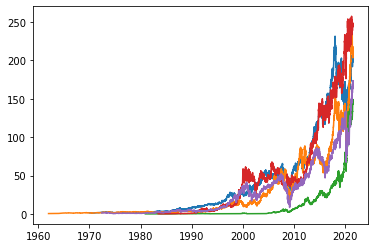

In [121]:
plt.plot(MMM)
plt.plot(CAT)
plt.plot(AAPL)
plt.plot(AMGN)
plt.plot(AXP)

In [122]:
MMM=MMM.tail(37)
AXP=AXP.tail(37)
AAPL=AAPL.tail(37)
AMGN=AMGN.tail(37)
CAT=CAT.tail(37)

In [123]:
stonks=[MMM,AXP,AAPL,AMGN,CAT]

In [124]:
train, test = temporal_train_test_split(MMM, test_size=30)
test_sq=test.squeeze()
train_sq=train.squeeze()
arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
       suppress_warnings=True, maxiter=100,seasonal=True, m=1)
y_pred = arima.predict(n_periods=test.shape[0])
y_true=test

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27.799, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=23.803, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=25.751, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=25.732, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=96.301, Time=0.00 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.229 seconds


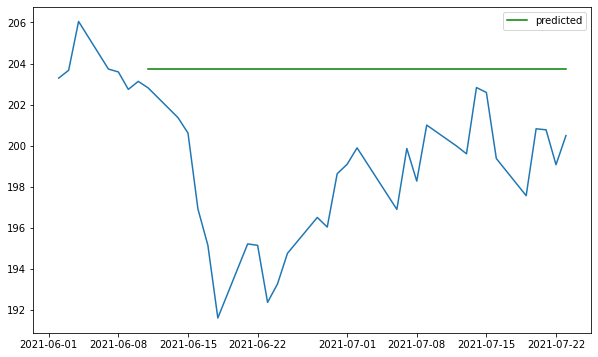

In [125]:
plt.figure(figsize=(10,6))
plt.plot(MMM)
plt.plot(test.index, y_pred, color='green', label = 'predicted')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=136.682, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=168.781, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=132.206, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=153.099, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=404.785, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=133.502, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=133.728, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=134.969, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.596 seconds


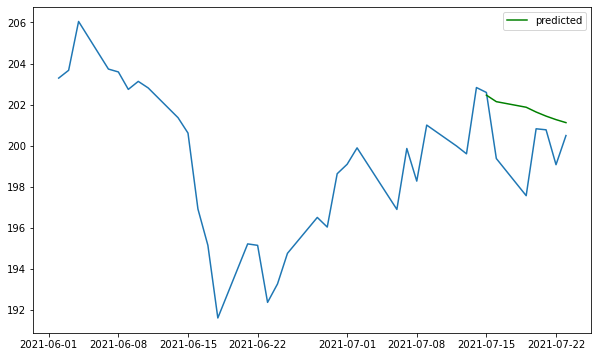

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=137.046, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=138.164, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=137.346, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=135.509, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.303 seconds


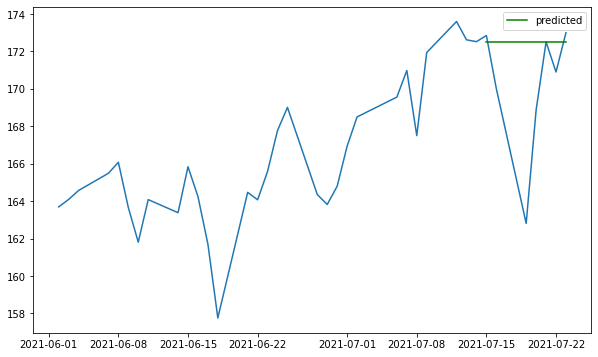

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=109.304, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105.311, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=105.317, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.110, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=112.190, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=105.874, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=107.365, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=114.008, Time=0.00 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.321 seconds


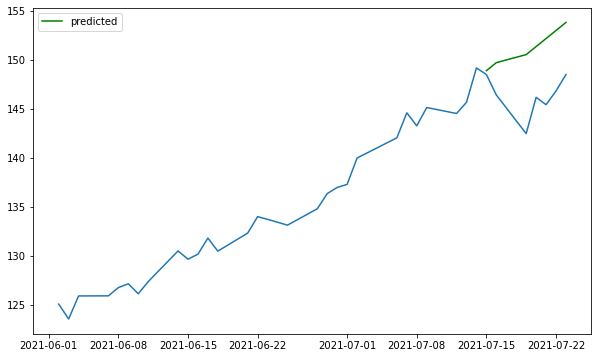

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=122.580, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=124.549, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=124.467, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=121.465, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=125.133, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.236 seconds


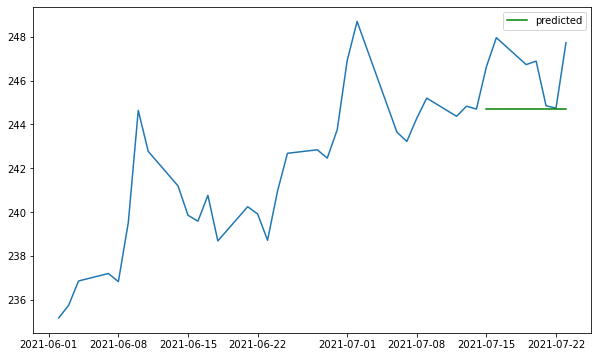

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=157.002, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=158.313, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=158.318, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=157.872, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=160.308, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.304 seconds


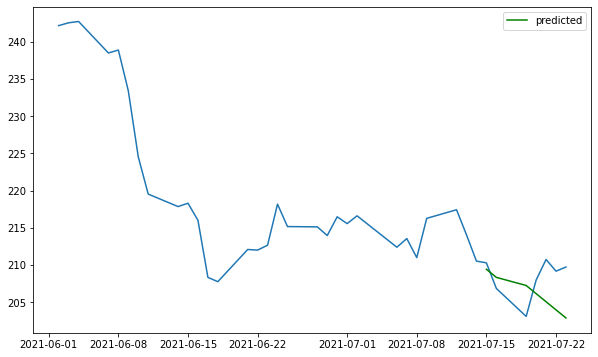

In [126]:
for each in stonks:    
    train, test = temporal_train_test_split(each, test_size=7)
    test_sq=test.squeeze()
    train_sq=train.squeeze()
    arima = pm.auto_arima(train_sq,error_action='ignore', trace=True,
           suppress_warnings=True, maxiter=100,seasonal=True, m=1)
    y_pred = arima.predict(n_periods=test.shape[0])
    y_true=test
    plt.figure(figsize=(10,6))
    plt.plot(each)
    plt.plot(test.index, y_pred, color='green', label = 'predicted')
    plt.legend()
    plt.show()

These results are all pretty terrible. In the next notebook, we'll try again with Prophet, Facebook's time forecasting library.